# Analiza danych do projektu Space-U
**Autorzy:** Karolina Bakalarz, Amelia Bieda, Agnieszka Staszkiewicz, Aleksandra Szczur, Paweł Wojarnik.

W poniższej analizie przedstawimy odpowiedzi na pytania:

1. Znajdź najpopularniejsze rodzaje wypraw, porównaj koszta i zyski, czy są opłacalne?
2. Sporządź wykres liczby obsłużonych klientów w każdym miesiącu działalności firmy, czy firma rośnie, czy podupada?
3. Sprawdź, po których wycieczkach klienci wracają na kolejne, a po których mają dość i więcej ich nie widzicie. Czy są takie, które być może powinny zniknąć z oferty?
4. Jakie typy wypraw generują najwięcej transakcji dodatkowych? Czy dodatkowe przychody są znaczące?
5. Czy pojazdy wykorzystywane w wyprawach są równomiernie eksploatowane? Czy niektóre są nadmiernie obciążane lub niewykorzystywane?
6. Czy istnieje grupa klientów, którzy do tej pory wydali najwięcej – i co ich łączy?
7. Ilu klientow jest uczulonych na gluten i ktore dania sa dla nich bezpieczne do spozywania na statku

In [ ]:
import mysql.connector # pip install mysql-connector-python
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import colorsys
from matplotlib.patches import Patch
from IPython.display import Markdown, display
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

conn = mysql.connector.connect(
    host="****.it",       
    user="****",          
    password="****",     
    database="****",      
    port=0000               
)

Łączymy z bazą danych, które będziemy analizować. Wyświetlamy co znajduje się w tej bazie.

In [ ]:

opisy_kolumn = {
    'adresy': {
        'adres_id': 'Unikalny identyfikator adresu',
        'miasto': 'Nazwa miasta, w którym znajduje się adres',
        'ulica_numer': 'Nazwa ulicy wraz z numerem budynku i ewentualnie lokalu',
        'kod_pocztowy': 'Kod pocztowy przypisany do adresu',
    },
    'alergeny': {
        'alergen_id': 'Unikalny identyfikator alergenu',
        'nazwa': 'Nazwa alergenu (np. gluten, mleko, orzechy)',
    },
    'jedzenie': {
        'jedzenie_id': 'Unikalny identyfikator pozycji jedzenia',
        'danie': 'Nazwa dania lub przekąski',
        'liczba_kalorii': 'Wartość kaloryczna dania w kilokaloriach',
        'rodzaj': 'Rodzaj posiłku, np. przekąska lub śniadanie',
        'czy_wegetarianskie': 'Wartość logiczna wskazująca, czy danie jest wegetariańskie (1 - tak, 0 - nie)',
        'czy_weganskie': 'Wartość logiczna wskazująca, czy danie jest wegańskie (1 - tak, 0 - nie)',
        'opis': 'Krótki opis dania lub składników',
    },
    'jedzenie_alergen': {
        'jedzenie_id': 'Identyfikator dania powiązanego z alergenem (klucz obcy do tabeli jedzenie)',
        'alergen_id': 'Identyfikator alergenu powiązanego z daniem (klucz obcy do tabeli alergeny)',
    },
    'kierunek': {
        'kierunek_id': 'Unikalny identyfikator kierunku lotu',
        'nazwa': 'Nazwa miejsca docelowego podróży kosmicznej',
    },
    'klient_alergen': {
    'klient_id': 'Identyfikator klienta powiązanego z alergenem (klucz obcy do tabeli klienci)',
    'alergen_id': 'Identyfikator alergenu przypisanego do klienta (klucz obcy do tabeli alergeny)'
    },
    'klienci': {
        'klient_id': 'Unikalny identyfikator klienta',
        'plec': 'Płeć klienta (M - mężczyzna, K - kobieta)',
        'imie': 'Imię klienta',
        'nazwisko': 'Nazwisko klienta',
        'e_mail': 'Adres e-mail klienta',
        'telefon': 'Numer telefonu kontaktowego klienta',
        'data_urodzenia': 'Data urodzenia klienta',
        'adres_id': 'Identyfikator adresu klienta (klucz obcy do tabeli adresy)',
        'czy_wegetarian': 'Wartość logiczna wskazująca, czy klient jest wegetarianinem (1 - tak, 0 - nie)',
        'czy_weganin': 'Wartość logiczna wskazująca, czy klient jest weganinem (1 - tak, 0 - nie)',
        'alergeny': 'Lista alergenów, na które klient ma uczulenie (oddzielone przecinkami)',
        'waga': 'Waga klienta w kilogramach',
        'wzrost': 'Wzrost klienta w centymetrach',
    },
    'kontakt_bliski': {
        'b_klienta_id': 'Unikalny identyfikator osoby bliskiej klienta',
        'klient_id': 'Identyfikator klienta, z którym powiązana jest osoba bliska (klucz obcy do tabeli klienci)',
        'imie': 'Imię osoby bliskiej klienta',
        'nazwisko': 'Nazwisko osoby bliskiej klienta',
        'relacja': 'Rodzaj relacji z klientem (np. żona, brat, ojciec)',
        'telefon': 'Numer telefonu osoby bliskiej',
        'email': 'Adres e-mail osoby bliskiej',
    },
    'koszty_organizacji': {
        'koszt_id': 'Unikalny identyfikator kosztu',
        'wyprawa_id': 'Identyfikator wyprawy, której dotyczy koszt (klucz obcy do tabeli wyprawy)',
        'rodzaj_kosztu_id': 'Identyfikator rodzaju kosztu (klucz obcy do tabeli rodzaje_kosztow)',
        'kwota_pln': 'Wartość kosztu wyrażona w złotówkach',
    },
    'metody_platnosci': {
        'metoda_id': 'Unikalny identyfikator metody płatności',
        'nazwa': 'Nazwa metody płatności (np. karta, bitcoin)',
    },
    'pojazdy': {
        'pojazd_id': 'Unikalny identyfikator pojazdu',
        'nazwa': 'Numer rejestracyjny lub identyfikator pojazdu',
        'typ': 'Typ pojazdu (np. wycieczkowy, treningowy)',
        'maksymalny_udzwig_w_tonach': 'Maksymalny udźwig pojazdu w kilogramach',
        'liczba_miejsc': 'Liczba miejsc dostępnych dla pasażerów',
        'data_produkcji': 'Data produkcji pojazdu',
        'data_ostatniej_kontroli': 'Data ostatniej kontroli technicznej pojazdu',
        'producent': 'Nazwa producenta pojazdu',
    },
    'pracownicy': {
        'pracownik_id': 'Unikalny identyfikator pracownika',
        'plec': 'Płeć pracownika (M - mężczyzna, K - kobieta)',
        'imie': 'Imię pracownika',
        'nazwisko': 'Nazwisko pracownika',
        'data_urodzenia': 'Data urodzenia pracownika',
        'adres_id': 'Identyfikator adresu pracownika (klucz obcy do tabeli adresy)',
        'stanowisko_id': 'Identyfikator stanowiska pracownika (klucz obcy do tabeli stanowiska)',
        'staz_w_firmie': 'Staż pracy pracownika w firmie (np. <1 rok, >5 lat)',
        'wynagrodzenie_miesięczne': 'Wynagrodzenie brutto pracownika w złotówkach',
        'email': 'Adres e-mail pracownika',
        'telefon': 'Numer telefonu pracownika',
    },
    'rodzaje_kosztow': {
        'rodzaj_kosztu_id': 'Unikalny identyfikator rodzaju kosztu',
        'nazwa': 'Nazwa rodzaju kosztu (np. Paliwo, Jedzenie i picie)',
        'min_kwota': 'Minimalna kwota szacunkowa dla danego rodzaju kosztu',
        'max_kwota': 'Maksymalna kwota szacunkowa dla danego rodzaju kosztu',
    },
    'stanowiska': {
        'stanowisko_id': 'Unikalny identyfikator stanowiska',
        'nazwa': 'Nazwa stanowiska (np. Księgowy, Lekarz misji, Technik rakietowy)',
    },
    'transakcje': {
        'transakcja_id': 'Unikalny identyfikator transakcji',
        'klient_id': 'Identyfikator klienta, który dokonał transakcji (klucz obcy do tabeli klienci)',
        'wyprawa_id': 'Identyfikator wyprawy (klucz obcy do tabeli wyprawy)',
        'data_transakcji': 'Data wykonania transakcji',
        'kwota_za_wyprawe_mln': 'Kwota zapłacona za udział w wyprawie (bez atrakcji dodatkowych)',
        'czy_dod_atrakcja': 'Informacja, czy klient wybrał atrakcję dodatkową (Tak/Nie)',
        'kwota_atrakcji': 'Kwota zapłacona za atrakcję dodatkową (jeśli dotyczy)',
        'metoda_id': 'Identyfikator metody płatności (klucz obcy do tabeli metody_platnosci)',
    },
    'uczestnicy_wyprawy': {
        'klient_id': 'Identyfikator klienta biorącego udział w wyprawie (klucz obcy do tabeli klienci)',
        'wyprawa_id': 'Identyfikator wyprawy, w której uczestniczył klient (klucz obcy do tabeli wyprawy)',
    },

    'wyprawy': {
        'wyprawa_id': 'Identyfikator wyprawy',
        'data_startu': 'Data rozpoczęcia wyprawy',
        'data_powrotu': 'Data zakończenia wyprawy',
        'pojazd_id': 'Identyfikator pojazdu użytego w wyprawie (klucz obcy do tabeli pojazdy)',
        'rodzaj_wyprawy_id': 'Identyfikator rodzaju wyprawy (klucz obcy do tabeli rodzaje_wypraw)',
        'status': 'Status wyprawy (np. zakończona, zaplanowana)',
    },
    'rodzaje_wypraw': {
        'rodzaj_wyprawy_id': 'Identyfikator rodzaju wyprawy',
        'nazwa': 'Nazwa rodzaju wyprawy (np. „Orbitalny weekend”, „Misja na Księżyc”)',
        'opis': 'Opis wyprawy (np. cel i przebieg wyprawy)',
        'cena_wyprawy_mln': 'Cena całkowita wyprawy bez dodatkowych atrakcji',
        'czas_trwania_dni': 'Czas trwania wyprawy w dniach',
        'dodatkowe_aktywnosci': 'Opis dodatkowych atrakcji dostępnych podczas wyprawy',
        'cena_aktywnosci_zl': 'Cena za dodatkowe aktywności (jeśli klient je wybierze)',
        'kierunek_id': 'Identyfikator kierunku podróży (klucz obcy do tabeli kierunek)'
    }
}


cursor = conn.cursor()
cursor.execute("SHOW TABLES")
tabele = cursor.fetchall()

for (tabela,) in tabele:

    cursor.execute(f"SHOW COLUMNS FROM {tabela}")
    kolumny = cursor.fetchall()

    dane = []
    for kol in kolumny:
        nazwa = kol[0]
        typ = kol[1]
        opis = opisy_kolumn.get(tabela, {}).get(nazwa, "")  # szukamy opisu w konkretnej tabeli
        dane.append((nazwa, typ, opis))

    df = pd.DataFrame(dane, columns=["Nazwa kolumny", "Typ kolumny", "Opis"])

    md_table = tabulate(df, headers='keys', tablefmt='github', showindex=False)
    display(Markdown(f"**Tabela:** {tabela}\n\n{md_table}"))
cursor.close()


**Tabela:** adresy

| Nazwa kolumny   | Typ kolumny   | Opis                                                    |
|-----------------|---------------|---------------------------------------------------------|
| adres_id        | int(11)       | Unikalny identyfikator adresu                           |
| miasto          | varchar(50)   | Nazwa miasta, w którym znajduje się adres               |
| ulica_numer     | varchar(100)  | Nazwa ulicy wraz z numerem budynku i ewentualnie lokalu |
| kod_pocztowy    | varchar(10)   | Kod pocztowy przypisany do adresu                       |

**Tabela:** alergeny

| Nazwa kolumny   | Typ kolumny   | Opis                                        |
|-----------------|---------------|---------------------------------------------|
| alergen_id      | int(11)       | Unikalny identyfikator alergenu             |
| nazwa           | varchar(50)   | Nazwa alergenu (np. gluten, mleko, orzechy) |

**Tabela:** jedzenie

| Nazwa kolumny      | Typ kolumny   | Opis                                                                          |
|--------------------|---------------|-------------------------------------------------------------------------------|
| jedzenie_id        | varchar(10)   | Unikalny identyfikator pozycji jedzenia                                       |
| danie              | varchar(100)  | Nazwa dania lub przekąski                                                     |
| liczba_kalorii     | int(11)       | Wartość kaloryczna dania w kilokaloriach                                      |
| rodzaj             | varchar(30)   | Rodzaj posiłku, np. przekąska lub śniadanie                                   |
| czy_wegetarianskie | tinyint(1)    | Wartość logiczna wskazująca, czy danie jest wegetariańskie (1 - tak, 0 - nie) |
| czy_weganskie      | tinyint(1)    | Wartość logiczna wskazująca, czy danie jest wegańskie (1 - tak, 0 - nie)      |
| opis               | text          | Krótki opis dania lub składników                                              |

**Tabela:** jedzenie_alergen

| Nazwa kolumny   | Typ kolumny   | Opis                                                                        |
|-----------------|---------------|-----------------------------------------------------------------------------|
| jedzenie_id     | varchar(10)   | Identyfikator dania powiązanego z alergenem (klucz obcy do tabeli jedzenie) |
| alergen_id      | int(11)       | Identyfikator alergenu powiązanego z daniem (klucz obcy do tabeli alergeny) |

**Tabela:** kierunek

| Nazwa kolumny   | Typ kolumny   | Opis                                        |
|-----------------|---------------|---------------------------------------------|
| kierunek_id     | varchar(10)   | Unikalny identyfikator kierunku lotu        |
| nazwa           | varchar(50)   | Nazwa miejsca docelowego podróży kosmicznej |

**Tabela:** klienci

| Nazwa kolumny   | Typ kolumny   | Opis                                                                           |
|-----------------|---------------|--------------------------------------------------------------------------------|
| klient_id       | int(11)       | Unikalny identyfikator klienta                                                 |
| plec            | varchar(1)    | Płeć klienta (M - mężczyzna, K - kobieta)                                      |
| imie            | varchar(50)   | Imię klienta                                                                   |
| nazwisko        | varchar(50)   | Nazwisko klienta                                                               |
| e_mail          | varchar(100)  | Adres e-mail klienta                                                           |
| telefon         | varchar(20)   | Numer telefonu kontaktowego klienta                                            |
| data_urodzenia  | date          | Data urodzenia klienta                                                         |
| adres_id        | int(11)       | Identyfikator adresu klienta (klucz obcy do tabeli adresy)                     |
| czy_wegetarian  | tinyint(1)    | Wartość logiczna wskazująca, czy klient jest wegetarianinem (1 - tak, 0 - nie) |
| czy_weganin     | tinyint(1)    | Wartość logiczna wskazująca, czy klient jest weganinem (1 - tak, 0 - nie)      |
| alergeny        | text          | Lista alergenów, na które klient ma uczulenie (oddzielone przecinkami)         |
| waga            | decimal(5,2)  | Waga klienta w kilogramach                                                     |
| wzrost          | int(11)       | Wzrost klienta w centymetrach                                                  |

**Tabela:** klient_alergen

| Nazwa kolumny   | Typ kolumny   | Opis                                                                           |
|-----------------|---------------|--------------------------------------------------------------------------------|
| klient_id       | int(11)       | Identyfikator klienta powiązanego z alergenem (klucz obcy do tabeli klienci)   |
| alergen_id      | int(11)       | Identyfikator alergenu przypisanego do klienta (klucz obcy do tabeli alergeny) |

**Tabela:** kontakt_bliski

| Nazwa kolumny   | Typ kolumny   | Opis                                                                                       |
|-----------------|---------------|--------------------------------------------------------------------------------------------|
| b_klienta_id    | varchar(20)   | Unikalny identyfikator osoby bliskiej klienta                                              |
| klient_id       | varchar(10)   | Identyfikator klienta, z którym powiązana jest osoba bliska (klucz obcy do tabeli klienci) |
| imie            | varchar(50)   | Imię osoby bliskiej klienta                                                                |
| nazwisko        | varchar(50)   | Nazwisko osoby bliskiej klienta                                                            |
| relacja         | varchar(20)   | Rodzaj relacji z klientem (np. żona, brat, ojciec)                                         |
| telefon         | varchar(20)   | Numer telefonu osoby bliskiej                                                              |
| email           | varchar(100)  | Adres e-mail osoby bliskiej                                                                |

**Tabela:** koszty_organizacji

| Nazwa kolumny    | Typ kolumny   | Opis                                                                       |
|------------------|---------------|----------------------------------------------------------------------------|
| koszt_id         | int(11)       | Unikalny identyfikator kosztu                                              |
| wyprawa_id       | varchar(10)   | Identyfikator wyprawy, której dotyczy koszt (klucz obcy do tabeli wyprawy) |
| rodzaj_kosztu_id | int(11)       | Identyfikator rodzaju kosztu (klucz obcy do tabeli rodzaje_kosztow)        |
| kwota_pln        | decimal(15,2) | Wartość kosztu wyrażona w złotówkach                                       |

**Tabela:** metody_platnosci

| Nazwa kolumny   | Typ kolumny   | Opis                                        |
|-----------------|---------------|---------------------------------------------|
| metoda_id       | int(11)       | Unikalny identyfikator metody płatności     |
| nazwa           | varchar(50)   | Nazwa metody płatności (np. karta, bitcoin) |

**Tabela:** pojazdy

| Nazwa kolumny              | Typ kolumny   | Opis                                          |
|----------------------------|---------------|-----------------------------------------------|
| pojazd_id                  | varchar(10)   | Unikalny identyfikator pojazdu                |
| nazwa                      | varchar(50)   | Numer rejestracyjny lub identyfikator pojazdu |
| typ                        | varchar(50)   | Typ pojazdu (np. wycieczkowy, treningowy)     |
| maksymalny_udzwig_w_tonach | int(11)       | Maksymalny udźwig pojazdu w kilogramach       |
| liczba_miejsc              | int(11)       | Liczba miejsc dostępnych dla pasażerów        |
| data_produkcji             | date          | Data produkcji pojazdu                        |
| data_ostatniej_kontroli    | date          | Data ostatniej kontroli technicznej pojazdu   |
| producent                  | varchar(50)   | Nazwa producenta pojazdu                      |

**Tabela:** pracownicy

| Nazwa kolumny            | Typ kolumny   | Opis                                                                  |
|--------------------------|---------------|-----------------------------------------------------------------------|
| pracownik_id             | varchar(10)   | Unikalny identyfikator pracownika                                     |
| plec                     | varchar(1)    | Płeć pracownika (M - mężczyzna, K - kobieta)                          |
| imie                     | varchar(50)   | Imię pracownika                                                       |
| nazwisko                 | varchar(50)   | Nazwisko pracownika                                                   |
| data_urodzenia           | date          | Data urodzenia pracownika                                             |
| adres_id                 | int(11)       | Identyfikator adresu pracownika (klucz obcy do tabeli adresy)         |
| stanowisko_id            | int(11)       | Identyfikator stanowiska pracownika (klucz obcy do tabeli stanowiska) |
| staz_w_firmie            | varchar(20)   | Staż pracy pracownika w firmie (np. <1 rok, >5 lat)                   |
| wynagrodzenie_miesięczne | decimal(10,2) | Wynagrodzenie brutto pracownika w złotówkach                          |
| email                    | varchar(100)  | Adres e-mail pracownika                                               |
| telefon                  | varchar(20)   | Numer telefonu pracownika                                             |

**Tabela:** rodzaje_kosztow

| Nazwa kolumny    | Typ kolumny   | Opis                                                  |
|------------------|---------------|-------------------------------------------------------|
| rodzaj_kosztu_id | int(11)       | Unikalny identyfikator rodzaju kosztu                 |
| nazwa            | varchar(100)  | Nazwa rodzaju kosztu (np. Paliwo, Jedzenie i picie)   |
| min_kwota        | decimal(15,2) | Minimalna kwota szacunkowa dla danego rodzaju kosztu  |
| max_kwota        | decimal(15,2) | Maksymalna kwota szacunkowa dla danego rodzaju kosztu |

**Tabela:** rodzaje_wypraw

| Nazwa kolumny        | Typ kolumny   | Opis                                                                |
|----------------------|---------------|---------------------------------------------------------------------|
| rodzaj_wyprawy_id    | varchar(10)   | Identyfikator rodzaju wyprawy                                       |
| nazwa                | varchar(100)  | Nazwa rodzaju wyprawy (np. „Orbitalny weekend”, „Misja na Księżyc”) |
| opis                 | text          | Opis wyprawy (np. cel i przebieg wyprawy)                           |
| cena_wyprawy_mln     | decimal(10,2) | Cena całkowita wyprawy bez dodatkowych atrakcji                     |
| czas_trwania_dni     | int(11)       | Czas trwania wyprawy w dniach                                       |
| dodatkowe_aktywnosci | text          | Opis dodatkowych atrakcji dostępnych podczas wyprawy                |
| cena_aktywnosci_zl   | bigint(20)    | Cena za dodatkowe aktywności (jeśli klient je wybierze)             |
| kierunek_id          | varchar(10)   | Identyfikator kierunku podróży (klucz obcy do tabeli kierunek)      |

**Tabela:** stanowiska

| Nazwa kolumny   | Typ kolumny   | Opis                                                             |
|-----------------|---------------|------------------------------------------------------------------|
| stanowisko_id   | int(11)       | Unikalny identyfikator stanowiska                                |
| nazwa           | varchar(100)  | Nazwa stanowiska (np. Księgowy, Lekarz misji, Technik rakietowy) |

**Tabela:** transakcje

| Nazwa kolumny        | Typ kolumny   | Opis                                                                           |
|----------------------|---------------|--------------------------------------------------------------------------------|
| transakcja_id        | varchar(10)   | Unikalny identyfikator transakcji                                              |
| klient_id            | int(11)       | Identyfikator klienta, który dokonał transakcji (klucz obcy do tabeli klienci) |
| wyprawa_id           | varchar(10)   | Identyfikator wyprawy (klucz obcy do tabeli wyprawy)                           |
| data_transakcji      | date          | Data wykonania transakcji                                                      |
| kwota_za_wyprawe_mln | decimal(10,2) | Kwota zapłacona za udział w wyprawie (bez atrakcji dodatkowych)                |
| czy_dod_atrakcja     | varchar(5)    | Informacja, czy klient wybrał atrakcję dodatkową (Tak/Nie)                     |
| kwota_atrakcji       | int(11)       | Kwota zapłacona za atrakcję dodatkową (jeśli dotyczy)                          |
| metoda_id            | int(11)       | Identyfikator metody płatności (klucz obcy do tabeli metody_platnosci)         |

**Tabela:** uczestnicy_wyprawy

| Nazwa kolumny   | Typ kolumny   | Opis                                                                               |
|-----------------|---------------|------------------------------------------------------------------------------------|
| klient_id       | int(11)       | Identyfikator klienta biorącego udział w wyprawie (klucz obcy do tabeli klienci)   |
| wyprawa_id      | varchar(10)   | Identyfikator wyprawy, w której uczestniczył klient (klucz obcy do tabeli wyprawy) |

**Tabela:** wyprawy

| Nazwa kolumny     | Typ kolumny   | Opis                                                                    |
|-------------------|---------------|-------------------------------------------------------------------------|
| wyprawa_id        | varchar(10)   | Identyfikator wyprawy                                                   |
| data_startu       | date          | Data rozpoczęcia wyprawy                                                |
| data_powrotu      | date          | Data zakończenia wyprawy                                                |
| pojazd_id         | varchar(10)   | Identyfikator pojazdu użytego w wyprawie (klucz obcy do tabeli pojazdy) |
| rodzaj_wyprawy_id | varchar(10)   | Identyfikator rodzaju wyprawy (klucz obcy do tabeli rodzaje_wypraw)     |
| status            | varchar(20)   | Status wyprawy (np. zakończona, zaplanowana)                            |

True

## Najpopularniejsze rodzaje wypraw, porównanie kosztów i zysków

- **Tabela wszystkich wypraw z ich statusem**

In [3]:
popularnosc = pd.read_sql("""
SELECT 
    r.rodzaj_wyprawy_id as ID, 
    r.nazwa, 
    CAST(SUM(CASE WHEN w.status = 'zakończona' THEN 1 ELSE 0 END) AS INTEGER) AS zakończone,
    CAST(SUM(CASE WHEN w.status = 'zaplanowana' THEN 1 ELSE 0 END) AS INTEGER) AS zaplanowane,
    COUNT(w.wyprawa_id) AS suma
FROM rodzaje_wypraw r
LEFT JOIN wyprawy w ON w.rodzaj_wyprawy_id = r.rodzaj_wyprawy_id
GROUP BY r.rodzaj_wyprawy_id, r.nazwa
ORDER BY suma DESC
""", conn)
md_table = tabulate(popularnosc, headers='keys', tablefmt='github', showindex=False)
display(Markdown(f"**Tabela:** {tabela}\n\n{md_table}"))



**Tabela:** wyprawy

| ID   | nazwa              |   zakończone |   zaplanowane |   suma |
|------|--------------------|--------------|---------------|--------|
| R03  | Jak podbić księżyc |            3 |             0 |      3 |
| R04  | Pierwszy krok      |            3 |             0 |      3 |
| R09  | Zimny księżyc      |            0 |             2 |      2 |
| R08  | Oko Ziemi          |            2 |             0 |      2 |
| R07  | Gwiezdźisty pas    |            1 |             1 |      2 |
| R01  | Orbitalny weekend  |            1 |             0 |      1 |
| R06  | W poszukiwaniu UFO |            1 |             0 |      1 |
| R05  | Czerwona stacja    |            1 |             0 |      1 |
| R02  | Misja na księżyc   |            1 |             0 |      1 |

In [4]:
def generuj_wnioski_opisowe(df: pd.DataFrame) -> list:
    wnioski = []

    if df.empty or df['suma'].sum() == 0:
        return ["Brak danych o wyprawach lub suma wszystkich wypraw wynosi 0."]

    # 1. Najpopularniejsze wyprawy
    top = df[df['suma'] == df['suma'].max()]
    if len(top) == 1:
        row = top.iloc[0]
        wnioski.append(f'"{row["nazwa"]}" to najczęściej wybierany rodzaj wyprawy – zrealizowano aż {row["zakończone"]} zakończonych wypraw.')
    else:
        wspolne = ', '.join(f'"{r["nazwa"]}"' for _, r in top.iterrows())
        wnioski.append(f'Najczęściej wybierane wyprawy to: {wspolne} – każda z łączną liczbą {top["suma"].iloc[0]}.')

    # 2. Wyprawy wyłącznie zakończone
    if df['zaplanowane'].sum() == 0:
        wnioski.append("Wszystkie wyprawy w zestawieniu to wyłącznie zakończone misje – brak aktualnie zaplanowanych wypraw.")

    # 3. Wyprawy bez żadnych realizacji
    brak = df[df['suma'] == 0]
    if not brak.empty:
        brak_lista = ', '.join(f'"{r["nazwa"]}"' for _, r in brak.iterrows())
        wnioski.append(f'Następujące wyprawy nie były jeszcze realizowane ani planowane: {brak_lista}.')

    # 4. Wyprawy jednorazowe
    jednorazowe = df[df['suma'] == 1]
    if not jednorazowe.empty:
        j_list = ', '.join(f'"{r["nazwa"]}"' for _, r in jednorazowe.iterrows())
        wnioski.append(f'{j_list} to wyprawy zrealizowane tylko jeden raz – co może świadczyć o ich mniejszym znaczeniu operacyjnym.')

    # 5. Wyprawy z najwyższym stosunkiem zakończonych do zaplanowanych
    if (df['zaplanowane'] + df['zakończone'] > 0).any():
        df['stosunek_zakonc_zaplan'] = df['zakończone'] / (df['zaplanowane'] + df['zakończone'])
        max_stosunek = df['stosunek_zakonc_zaplan'].max()
        top_stosunki = df[df['stosunek_zakonc_zaplan'] == max_stosunek]
        if max_stosunek > 0:
            wyprawy = ', '.join(f'"{r["nazwa"]}"' for _, r in top_stosunki.iterrows())
            wnioski.append(f'Wyprawy {wyprawy} cechują się najwyższym stosunkiem zakończonych do zaplanowanych wypraw ({max_stosunek:.2f}), co wskazuje na wysoką realizację planów.')

    # 6. Wyprawy z dużą liczbą zaplanowanych, ale niską liczbą zakończonych
    if (df['zaplanowane'] > 0).any():
        df['roznica'] = df['zaplanowane'] - df['zakończone']
        duza_roznica = df[df['roznica'] > 0].sort_values('roznica', ascending=False)
        if not duza_roznica.empty:
            top_roznica = duza_roznica.iloc[0]
            wnioski.append(f'Wyprawa "{top_roznica["nazwa"]}" ma dużą liczbę zaplanowanych wypraw ({top_roznica["zaplanowane"]}), ale stosunkowo mało zakończonych ({top_roznica["zakończone"]}), co może wskazywać na opóźnienia lub problemy operacyjne.')

    return wnioski



wnioski = generuj_wnioski_opisowe(popularnosc)
markdown_text = "\n".join(f"* {w}" for w in wnioski)

display(Markdown(markdown_text))


* Najczęściej wybierane wyprawy to: "Jak podbić księżyc", "Pierwszy krok" – każda z łączną liczbą 3.
* "Orbitalny weekend", "W poszukiwaniu UFO", "Czerwona stacja", "Misja na księżyc" to wyprawy zrealizowane tylko jeden raz – co może świadczyć o ich mniejszym znaczeniu operacyjnym.
* Wyprawy "Jak podbić księżyc", "Pierwszy krok", "Oko Ziemi", "Orbitalny weekend", "W poszukiwaniu UFO", "Czerwona stacja", "Misja na księżyc" cechują się najwyższym stosunkiem zakończonych do zaplanowanych wypraw (1.00), co wskazuje na wysoką realizację planów.
* Wyprawa "Zimny księżyc" ma dużą liczbę zaplanowanych wypraw (2), ale stosunkowo mało zakończonych (0), co może wskazywać na opóźnienia lub problemy operacyjne.

- **Wykres kołowy dla danych o rodzajach wypraw**

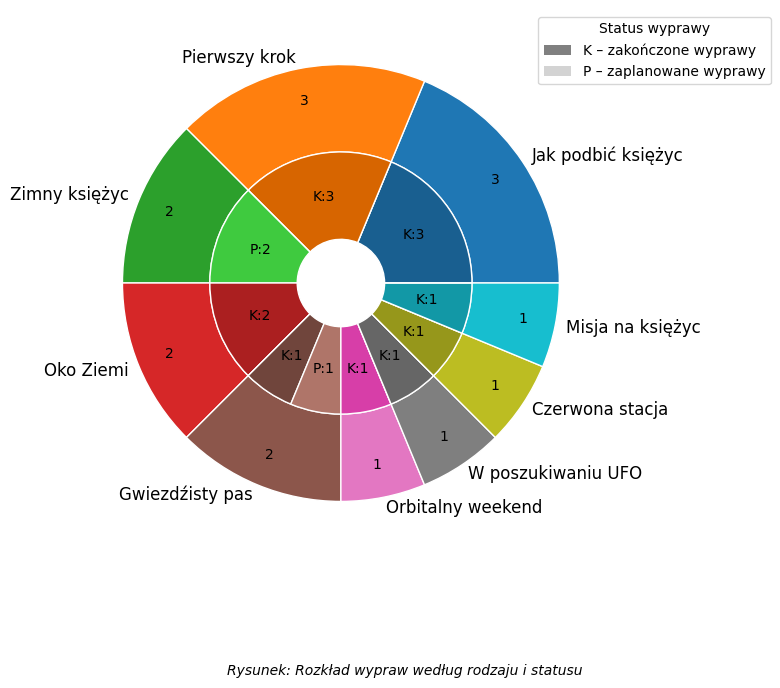

In [5]:
rodzaje = popularnosc['nazwa'].tolist()
zakonczone = popularnosc['zakończone'].tolist()
zaplanowane = popularnosc['zaplanowane'].tolist()
suma_wypraw = popularnosc['suma'].tolist()

dane_wewnetrzne = np.array([[z, p] for z, p in zip(zakonczone, zaplanowane)]).flatten()

# Funkcja do rozjaśniania/ściemniania koloru
def adjust_lightness(color, factor=1.2):
    c = to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(*c)
    l = min(1, max(0, l * factor))
    return colorsys.hls_to_rgb(h, l, s)

# Kolory bazowe – jeden dla każdej wyprawy
base_colors = plt.cm.get_cmap('tab10', len(rodzaje))
outer_colors = [base_colors(i) for i in range(len(rodzaje))]

# Wewnętrzne kolory – odcienie bazowych
inner_colors = []
for color in outer_colors:
    inner_colors.append(adjust_lightness(color, 0.8))  # zakończone
    inner_colors.append(adjust_lightness(color, 1.3))  # zaplanowane

# WYKRES
fig, ax = plt.subplots(figsize=(8,8))
size = 0.4
# Zewnętrzny pierścień
wedges_outer, _ = ax.pie(
    suma_wypraw,
    radius=1,
    colors=outer_colors,
    wedgeprops=dict(width=size, edgecolor='white'),
    labels=rodzaje,
    labeldistance=1.05,
    textprops={'fontsize': 12}
)
for i, wedge in enumerate(wedges_outer):
    ang = (wedge.theta2 + wedge.theta1) / 2
    x = 0.85 * np.cos(np.deg2rad(ang))
    y = 0.85 * np.sin(np.deg2rad(ang))
    ax.text(x, y, str(suma_wypraw[i]), ha='center', va='center', fontsize=10)

# Wewnętrzny pierścień
wedges_inner, _ = ax.pie(
    dane_wewnetrzne,
    radius=1 - size,
    colors=inner_colors,
    wedgeprops=dict(width=size, edgecolor='white')
)
for i, wedge in enumerate(wedges_inner):
    if dane_wewnetrzne[i] > 0:
        ang = (wedge.theta2 + wedge.theta1) / 2
        x = (0.6 - size / 2) * np.cos(np.deg2rad(ang))
        y = (0.6 - size / 2) * np.sin(np.deg2rad(ang))
        status = "K" if i % 2 == 0 else "P"
        ax.text(x, y, f"{status}:{int(dane_wewnetrzne[i])}", ha='center', va='center', fontsize=10)

legend_elements = [
    Patch(facecolor='gray', label='K – zakończone wyprawy'),
    Patch(facecolor='lightgray', label='P – zaplanowane wyprawy')
]
ax.legend(handles=legend_elements, title='Status wyprawy',
          loc='upper right', bbox_to_anchor=(1.3, 1))

plt.tight_layout()
plt.figtext(0.5, 0.01, "Rysunek: Rozkład wypraw według rodzaju i statusu", ha='center', fontsize=10, style='italic')
plt.show()



In [6]:
def generuj_wnioski_styl_opisowy(df: pd.DataFrame) -> list:
    wnioski = []

    # Najczęściej wybierane wyprawy (największa liczba zakończonych)
    max_zakonczone = df['zakończone'].max()
    top = df[df['zakończone'] == max_zakonczone]
    if not top.empty:
        if len(top) == 1:
            row = top.iloc[0]
            wnioski.append(f"„{row['nazwa']}” to najczęściej wybierana wyprawa – {row['zakończone']} zakończonych realizacji.")
        else:
            wyprawy = ' oraz '.join(f"„{r['nazwa']}”" for _, r in top.iterrows())
            wnioski.append(f"{wyprawy} to najczęściej wybierane wyprawy – po {max_zakonczone} zakończone realizacje każda, co wskazuje na ich dużą popularność.")

    # Wyprawy z 2 zakończonymi
    popularne = df[df['zakończone'] == 2]
    if not popularne.empty:
        if len(popularne) == 1:
            nazwa = popularne.iloc[0]['nazwa']
            wnioski.append(f"Wyprawa „{nazwa}” wyróżnia się dużym udziałem – 2 zakończone misje.")
        else:
            nazwy = ' oraz '.join(f"„{r['nazwa']}”" for _, r in popularne.iterrows())
            wnioski.append(f"Wyprawy takie jak {nazwy} również wyróżniają się dużym udziałem – po 2 zakończone misje każda.")

    # Wyprawy z samymi zaplanowanymi
    tylko_zaplanowane = df[(df['zaplanowane'] > 0) & (df['zakończone'] == 0)]
    for _, r in tylko_zaplanowane.iterrows():
        wnioski.append(f"Wyprawa „{r['nazwa']}” jest wyjątkowa, ponieważ wszystkie jej przypadki to wyprawy zaplanowane ({r['zaplanowane']}) – jeszcze żadna się nie zakończyła.")

    # Mieszane zakończone i zaplanowane
    mieszane = df[(df['zakończone'] > 0) & (df['zaplanowane'] > 0)]
    for _, r in mieszane.iterrows():
        wnioski.append(f"„{r['nazwa']}” to jedyny przypadek, gdzie występuje zarówno wyprawa zakończona (K:{r['zakończone']}) jak i zaplanowana (P:{r['zaplanowane']}) – może to wskazywać na kontynuację wcześniejszej misji.")

    # Wyprawy z 1 zakończoną
    pojedyncze = df[(df['zakończone'] == 1) & (df['zaplanowane'] == 0)]
    if not pojedyncze.empty:
        nazwy = ', '.join(f"„{r['nazwa']}”" for _, r in pojedyncze.iterrows())
        wnioski.append(f"{nazwy} mają tylko po jednej zakończonej wyprawie, co czyni je najmniej rozwiniętymi kierunkami działań.")

    # Brak całkowitych zer
    if (df['suma'] == 0).sum() == 0:
        wnioski.append("Brak wypraw o łącznej sumie równej 0 – każda pozycja zawiera przynajmniej jedną zakończoną lub zaplanowaną misję.")

    return wnioski

# Generowanie i wyświetlanie wniosków
wniosek =  generuj_wnioski_styl_opisowy(popularnosc)
markdown_text = "\n".join(f"* {w}" for w in wniosek)

display(Markdown(markdown_text))


* „Jak podbić księżyc” oraz „Pierwszy krok” to najczęściej wybierane wyprawy – po 3 zakończone realizacje każda, co wskazuje na ich dużą popularność.
* Wyprawa „Oko Ziemi” wyróżnia się dużym udziałem – 2 zakończone misje.
* Wyprawa „Zimny księżyc” jest wyjątkowa, ponieważ wszystkie jej przypadki to wyprawy zaplanowane (2) – jeszcze żadna się nie zakończyła.
* „Gwiezdźisty pas” to jedyny przypadek, gdzie występuje zarówno wyprawa zakończona (K:1) jak i zaplanowana (P:1) – może to wskazywać na kontynuację wcześniejszej misji.
* „Orbitalny weekend”, „W poszukiwaniu UFO”, „Czerwona stacja”, „Misja na księżyc” mają tylko po jednej zakończonej wyprawie, co czyni je najmniej rozwiniętymi kierunkami działań.
* Brak wypraw o łącznej sumie równej 0 – każda pozycja zawiera przynajmniej jedną zakończoną lub zaplanowaną misję.

- **Tabela kosztów i przychodów**

In [7]:
koszty = pd.read_sql( """
SELECT 
    w.wyprawa_id,
    r.nazwa AS rodzaj_wyprawy,
    SUM(k.kwota_pln) / 1000000 AS koszt_mln
FROM wyprawy w
JOIN koszty_organizacji k ON w.wyprawa_id = k.wyprawa_id
JOIN rodzaje_wypraw r ON w.rodzaj_wyprawy_id = r.rodzaj_wyprawy_id
GROUP BY w.wyprawa_id, r.nazwa
""", conn)

przychody = pd.read_sql( """
SELECT 
    wyprawa_id,
    SUM(kwota_za_wyprawe_mln) AS przychod_z_biletow_mln,
    SUM(kwota_atrakcji) / 1000 AS przychod_z_atrakcji_mln
FROM transakcje
GROUP BY wyprawa_id
""", conn)

# Łączenie danych
analiza = pd.merge(koszty, przychody, on='wyprawa_id', how='left').fillna(0)

# Obliczenia finansowe
analiza['przychod_calkowity_mln'] = analiza['przychod_z_biletow_mln'] + analiza['przychod_z_atrakcji_mln']
analiza['zysk_brutto_mln'] = analiza['przychod_calkowity_mln'] - analiza['koszt_mln']
analiza['ROI'] = (analiza['zysk_brutto_mln'] / analiza['koszt_mln']) * 100
analiza['marza'] = (analiza['zysk_brutto_mln'] / analiza['przychod_calkowity_mln']) * 100

# Formatowanie wyników
analiza['koszt_mln'] = analiza['koszt_mln'].round(2)
analiza['przychod_calkowity_mln'] = analiza['przychod_calkowity_mln'].round(2)
analiza['zysk_brutto_mln'] = analiza['zysk_brutto_mln'].round(2)
analiza['ROI'] = analiza['ROI'].round(1)
analiza['marza'] = analiza['marza'].round(1)

# Formatowanie wyników
analiza = analiza.round({
    'koszt_mln': 2,
    'przychod_calkowity_mln': 2,
    'zysk_brutto_mln': 2,
    'ROI': 1,
    'marza': 1
})

# Pierwsza tabela z 4 pierwszymi kolumnami
cols_1 = analiza.columns[:5]
tabela_1 = analiza[cols_1]

# Druga tabela z kolumną 'wyprawa_id' i resztą kolumn
cols_2 = ['wyprawa_id'] + [col for col in analiza.columns if col not in cols_1 and col != 'wyprawa_id']
tabela_2 = analiza[cols_2]

# Formatowanie i wyświetlanie pierwszej tabeli
md_table_1 = tabulate(tabela_1, headers='keys', tablefmt='github', showindex=False)
display(Markdown(f"**Tabela 1: Podstawowe dane wypraw**\n\n{md_table_1}"))

# Formatowanie i wyświetlanie drugiej tabeli
md_table_2 = tabulate(tabela_2, headers='keys', tablefmt='github', showindex=False)
display(Markdown(f"**Tabela 2: Szczegółowe dane finansowe wypraw**\n\n{md_table_2}"))


**Tabela 1: Podstawowe dane wypraw**

| wyprawa_id   | rodzaj_wyprawy     |   koszt_mln |   przychod_z_biletow_mln |   przychod_z_atrakcji_mln |
|--------------|--------------------|-------------|--------------------------|---------------------------|
| W01          | Orbitalny weekend  |       15.59 |                   515.1  |                    166.24 |
| W02          | Gwiezdźisty pas    |        2.05 |                 43276.7  |                      0    |
| W03          | Oko Ziemi          |       10.54 |                   229.08 |                     24.05 |
| W04          | Pierwszy krok      |        3    |                 48010    |                     86.42 |
| W05          | Jak podbić księżyc |       22.18 |                  1179.14 |                     26.68 |
| W06          | Pierwszy krok      |       23.73 |                 12002.5  |                     43.21 |
| W07          | Gwiezdźisty pas    |        6.7  |                     0    |                      0    |
| W08          | Misja na księżyc   |       13.31 |                   979.68 |                     20.38 |
| W09          | Pierwszy krok      |       16.65 |                 36007.5  |                     86.42 |
| W10          | Czerwona stacja    |       13.49 |                 37933.4  |                     33.11 |
| W11          | W poszukiwaniu UFO |        8.07 |                 30526.8  |                      0    |
| W12          | Zimny księżyc      |        8.62 |                 70845.3  |                      0    |
| W13          | Zimny księżyc      |        7.17 |                     0    |                      0    |
| W18          | Jak podbić księżyc |       18.17 |                   589.57 |                     26.68 |
| W19          | Oko Ziemi          |       11.03 |                   343.62 |                     72.15 |
| W20          | Jak podbić księżyc |       16.13 |                     0    |                      0    |

**Tabela 2: Szczegółowe dane finansowe wypraw**

| wyprawa_id   |   przychod_calkowity_mln |   zysk_brutto_mln |              ROI |   marza |
|--------------|--------------------------|-------------------|------------------|---------|
| W01          |                   681.34 |            665.75 |   4271           |    97.7 |
| W02          |                 43276.7  |          43274.6  |      2.11152e+06 |   100   |
| W03          |                   253.13 |            242.59 |   2302.5         |    95.8 |
| W04          |                 48096.5  |          48093.5  |      1.60564e+06 |   100   |
| W05          |                  1205.82 |           1183.64 |   5335.8         |    98.2 |
| W06          |                 12045.7  |          12022    |  50657.5         |    99.8 |
| W07          |                     0    |             -6.7  |   -100           |  -inf   |
| W08          |                  1000.06 |            986.75 |   7415.1         |    98.7 |
| W09          |                 36093.9  |          36077.3  | 216688           |   100   |
| W10          |                 37966.5  |          37953    | 281326           |   100   |
| W11          |                 30526.8  |          30518.7  | 378402           |   100   |
| W12          |                 70845.3  |          70836.7  | 821853           |   100   |
| W13          |                     0    |             -7.17 |   -100           |  -inf   |
| W18          |                   616.25 |            598.08 |   3291.4         |    97.1 |
| W19          |                   415.77 |            404.74 |   3668.3         |    97.3 |
| W20          |                     0    |            -16.13 |   -100           |  -inf   |

In [8]:
def generuj_wnioski_finansowe(analiza: pd.DataFrame) -> list:
    wnioski = []

    # Najbardziej dochodowa wyprawa
    top_zysk = analiza.loc[analiza['zysk_brutto_mln'].idxmax()]
    wnioski.append(
        f"Najbardziej dochodowa wyprawa to „{top_zysk['rodzaj_wyprawy']}” ({top_zysk['wyprawa_id']}), "
        f"która wygenerowała zysk brutto {top_zysk['zysk_brutto_mln']:,} mln zł – "
        f"{'mimo zerowych przychodów z atrakcji' if top_zysk['przychod_z_atrakcji_mln'] == 0 else 'przy istotnym udziale atrakcji'}."
    )

    # Najwyższy ROI
    analiza_filtered = analiza.replace([float('inf'), -float('inf')], pd.NA).dropna(subset=["ROI"])
    if not analiza_filtered.empty:
        top_roi = analiza_filtered.loc[analiza_filtered['ROI'].idxmax()]
        wnioski.append(
            f"Najwyższy zwrot z inwestycji (ROI) osiągnęła wyprawa „{top_roi['rodzaj_wyprawy']}” ({top_roi['wyprawa_id']}) – "
            f"ROI na poziomie aż {top_roi['ROI']}%, przy kosztach tylko {top_roi['koszt_mln']} mln zł "
            f"i łącznie ponad {top_roi['przychod_calkowity_mln']} mln zł przychodów."
        )

    # Straty finansowe
    straty = analiza[analiza['zysk_brutto_mln'] < 0]
    if not straty.empty:
        wnioski.append(
            f"{len(straty)} wyprawy zakończyły się stratą finansową, osiągając ujemny zysk brutto "
            f"oraz {'nieskończony (−∞) ' if any((analiza['ROI'] == float('-inf')) | (analiza['ROI'] == float('inf'))) else ''}ROI i marżę:"
        )
        for _, row in straty.iterrows():
            wnioski.append(f"– „{row['rodzaj_wyprawy']}” ({row['wyprawa_id']}) – strata {abs(row['zysk_brutto_mln']):.2f} mln zł.")

    # Brak przychodu
    brak_przychodu = analiza[analiza['przychod_calkowity_mln'] == 0]
    if not brak_przychodu.empty:
        wyprawy_nazwy = [f"{row['wyprawa_id']} („{row['rodzaj_wyprawy']}”)" for _, row in brak_przychodu.iterrows()]
        tekst_wypraw = ", ".join(wyprawy_nazwy)
        wnioski.append(
            f"Wyprawy {tekst_wypraw} nie wygenerowały żadnego przychodu, co sugeruje brak komercjalizacji lub błędy w strategii marketingowej."
        )


    # Największe przychody z atrakcji
    top_atrakcje = analiza.loc[analiza['przychod_z_atrakcji_mln'].idxmax()]
    if top_atrakcje['przychod_z_atrakcji_mln'] > 0:
        udzial = 100 * top_atrakcje['przychod_z_atrakcji_mln'] / top_atrakcje['przychod_calkowity_mln']
        wnioski.append(
            f"Największe przychody z atrakcji osiągnęła wyprawa „{top_atrakcje['rodzaj_wyprawy']}” ({top_atrakcje['wyprawa_id']}) – "
            f"aż {top_atrakcje['przychod_z_atrakcji_mln']:,} mln zł, co stanowiło ponad {udzial:.1f}% całkowitych przychodów tej misji."
        )

    # Średnia marża
    pozytywne = analiza[analiza['zysk_brutto_mln'] > 0]
    if not pozytywne.empty:
        srednia_marza = pozytywne['marza'].mean()
        wnioski.append(
            f"Średnia marża dla wypraw przynoszących zysk wynosi około {srednia_marza:.1f}%, "
            f"co świadczy o wysokiej rentowności większości operacji."
        )

    return wnioski


wnioski = generuj_wnioski_finansowe(analiza)
markdown_text = "\n".join(f"* {w}" for w in wnioski)

display(Markdown(markdown_text))



* Najbardziej dochodowa wyprawa to „Zimny księżyc” (W12), która wygenerowała zysk brutto 70,836.69 mln zł – mimo zerowych przychodów z atrakcji.
* Najwyższy zwrot z inwestycji (ROI) osiągnęła wyprawa „Gwiezdźisty pas” (W02) – ROI na poziomie aż 2111520.0%, przy kosztach tylko 2.05 mln zł i łącznie ponad 43276.66 mln zł przychodów.
* 3 wyprawy zakończyły się stratą finansową, osiągając ujemny zysk brutto oraz ROI i marżę:
* – „Gwiezdźisty pas” (W07) – strata 6.70 mln zł.
* – „Zimny księżyc” (W13) – strata 7.17 mln zł.
* – „Jak podbić księżyc” (W20) – strata 16.13 mln zł.
* Wyprawy W07 („Gwiezdźisty pas”), W13 („Zimny księżyc”), W20 („Jak podbić księżyc”) nie wygenerowały żadnego przychodu, co sugeruje brak komercjalizacji lub błędy w strategii marketingowej.
* Największe przychody z atrakcji osiągnęła wyprawa „Orbitalny weekend” (W01) – aż 166.24 mln zł, co stanowiło ponad 24.4% całkowitych przychodów tej misji.
* Średnia marża dla wypraw przynoszących zysk wynosi około 98.8%, co świadczy o wysokiej rentowności większości operacji.

- **Wykres kosztów, przychodów, średnich zysków brutto i zwrotów z inwestycji dla wypraw**

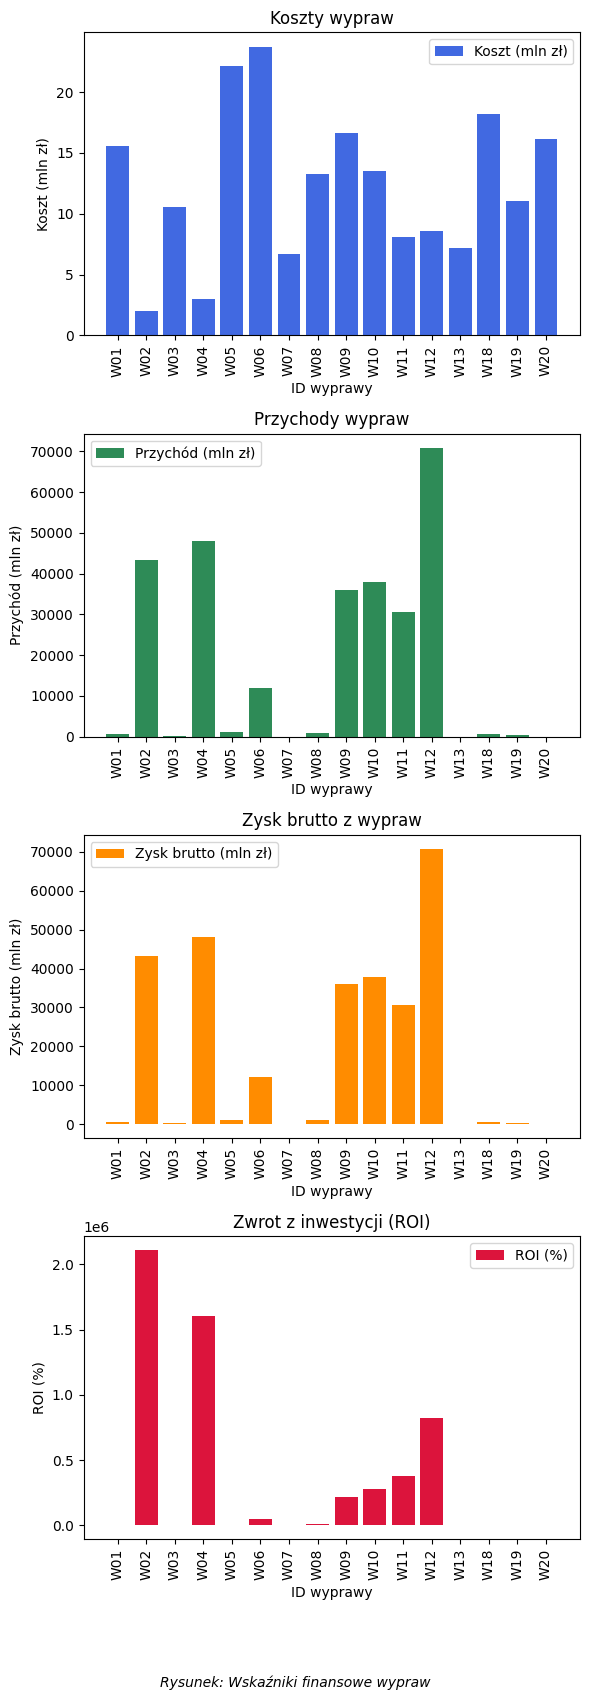

In [9]:
x_labels = analiza['wyprawa_id'].astype(str)

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(6, 18))
# Wykres kosztów
axes[0].bar(x_labels, analiza['koszt_mln'], color='royalblue', label='Koszt (mln zł)')
axes[0].set_title("Koszty wypraw")
axes[0].set_xlabel("ID wyprawy")
axes[0].set_ylabel("Koszt (mln zł)")
axes[0].tick_params(axis='x', rotation=90)
axes[0].legend()

# Wykres przychodów
axes[1].bar(x_labels, analiza['przychod_calkowity_mln'], color='seagreen', label='Przychód (mln zł)')
axes[1].set_title("Przychody wypraw")
axes[1].set_xlabel("ID wyprawy")
axes[1].set_ylabel("Przychód (mln zł)")
axes[1].tick_params(axis='x', rotation=90)
axes[1].legend()

# Wykres zysków
axes[2].bar(x_labels, analiza['zysk_brutto_mln'], color='darkorange', label='Zysk brutto (mln zł)')
axes[2].set_title("Zysk brutto z wypraw")
axes[2].set_xlabel("ID wyprawy")
axes[2].set_ylabel("Zysk brutto (mln zł)")
axes[2].tick_params(axis='x', rotation=90)
axes[2].legend()

# Wykres ROI
axes[3].bar(x_labels, analiza['ROI'], color='crimson', label='ROI (%)')
axes[3].set_title("Zwrot z inwestycji (ROI)")
axes[3].set_xlabel("ID wyprawy")
axes[3].set_ylabel("ROI (%)")
axes[3].tick_params(axis='x', rotation=90)
axes[3].legend()

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.text(0.5, 0.01, "Rysunek: Wskaźniki finansowe wypraw", ha='center', fontsize=10, style='italic')
plt.show()


In [10]:
import pandas as pd

def generuj_dokladne_wnioski(analiza: pd.DataFrame) -> str:
    analiza_filtered = analiza.replace([float('inf'), -float('inf')], pd.NA)

    # Pomocna funkcja do formatu "ID (Nazwa)"
    def id_nazwa(row):
        return f"{row['wyprawa_id']} („{row['rodzaj_wyprawy']}”)"

    najdrozsze = analiza.sort_values("koszt_mln", ascending=False).head(2)
    najtansze = analiza.sort_values("koszt_mln").head(2)
    najwiekszy_przychod = analiza.loc[analiza['przychod_calkowity_mln'].idxmax()]
    wysokie_przychody = analiza.sort_values("przychod_calkowity_mln", ascending=False).head(4)
    brak_przychodow = analiza[analiza['przychod_calkowity_mln'] == 0]
    top_zysk = analiza.loc[analiza['zysk_brutto_mln'].idxmax()]
    straty = analiza[analiza['zysk_brutto_mln'] < 0]
    niska_rentownosc = analiza[(analiza['koszt_mln'] > 20) & (analiza['zysk_brutto_mln'] < 15)]
    wysokie_roi = analiza_filtered[analiza_filtered['ROI'] > 1000000]
    ujemne_roi = analiza[analiza['ROI'] == float('-inf')]

    wnioski = f"""
Najwyższe koszty poniosły wyprawy {id_nazwa(najdrozsze.iloc[0])} oraz {id_nazwa(najdrozsze.iloc[1])}, które wyniosły odpowiednio {najdrozsze.iloc[0]['koszt_mln']:.2f} mln zł i {najdrozsze.iloc[1]['koszt_mln']:.2f} mln zł.  
Najtańsze okazały się wyprawy {id_nazwa(najtansze.iloc[0])} oraz {id_nazwa(najtansze.iloc[1])}, których koszty nie przekroczyły {max(najtansze['koszt_mln']):.2f} mln zł.

Najwyższy przychód uzyskała wyprawa {id_nazwa(najwiekszy_przychod)}, przekraczając łącznie {najwiekszy_przychod['przychod_calkowity_mln']:.2f} mln zł.  
Znaczące przychody zanotowały także wyprawy: {', '.join(id_nazwa(row) for _, row in wysokie_przychody.iloc[1:].iterrows())}.  
{f"Wyprawy {', '.join(id_nazwa(row) for _, row in brak_przychodow.iterrows())} nie wygenerowały żadnych przychodów, co może wskazywać na brak komercjalizacji lub problemy ze strategią marketingową." if not brak_przychodow.empty else ""}

Wyprawa {id_nazwa(top_zysk)} osiągnęła najwyższy zysk brutto na poziomie {top_zysk['zysk_brutto_mln']:.2f} mln zł.  
{f"Mimo wysokich kosztów, wyprawy takie jak {', '.join(id_nazwa(row) for _, row in niska_rentownosc.iterrows())} uzyskały stosunkowo niskie zyski." if not niska_rentownosc.empty else ""}  
{f"{len(straty)} wypraw zakończyło się stratą finansową, m.in. {', '.join(id_nazwa(row) for _, row in straty.iterrows())}." if not straty.empty else ""}

{f"Kilka wypraw, m.in. {', '.join(id_nazwa(row) for _, row in wysokie_roi.iterrows())}, wykazało ekstremalnie wysoki wskaźnik ROI." if not wysokie_roi.empty else ""}  
{f"Wyprawy zakończone stratą, takie jak {', '.join(id_nazwa(row) for _, row in ujemne_roi.iterrows())}, mają wskaźnik ROI równy minus nieskończoność (−∞)." if not ujemne_roi.empty else ""}  
{f"Przy relatywnie niskich przychodach, wysokie ROI zanotowano m.in. dla wypraw: {', '.join(analiza.loc[(analiza['ROI'] > 100000) & (analiza['przychod_calkowity_mln'] < 1000), 'wyprawa_id'].tolist())}." if not analiza.loc[(analiza['ROI'] > 100000) & (analiza['przychod_calkowity_mln'] < 1000)].empty else ""}
"""
    return wnioski.strip()

wnioski = generuj_dokladne_wnioski(analiza)

markdown_text = "\n".join(f"* {line.strip()}" for line in wnioski.split('\n') if line.strip())

display(Markdown(markdown_text))




* Najwyższe koszty poniosły wyprawy W06 („Pierwszy krok”) oraz W05 („Jak podbić księżyc”), które wyniosły odpowiednio 23.73 mln zł i 22.18 mln zł.
* Najtańsze okazały się wyprawy W02 („Gwiezdźisty pas”) oraz W04 („Pierwszy krok”), których koszty nie przekroczyły 3.00 mln zł.
* Najwyższy przychód uzyskała wyprawa W12 („Zimny księżyc”), przekraczając łącznie 70845.31 mln zł.
* Znaczące przychody zanotowały także wyprawy: W04 („Pierwszy krok”), W02 („Gwiezdźisty pas”), W10 („Czerwona stacja”).
* Wyprawy W07 („Gwiezdźisty pas”), W13 („Zimny księżyc”), W20 („Jak podbić księżyc”) nie wygenerowały żadnych przychodów, co może wskazywać na brak komercjalizacji lub problemy ze strategią marketingową.
* Wyprawa W12 („Zimny księżyc”) osiągnęła najwyższy zysk brutto na poziomie 70836.69 mln zł.
* 3 wypraw zakończyło się stratą finansową, m.in. W07 („Gwiezdźisty pas”), W13 („Zimny księżyc”), W20 („Jak podbić księżyc”).
* Kilka wypraw, m.in. W02 („Gwiezdźisty pas”), W04 („Pierwszy krok”), wykazało ekstremalnie wysoki wskaźnik ROI.

- **Wykres kołowy struktury przychodów** (bilety vs atrakcje)

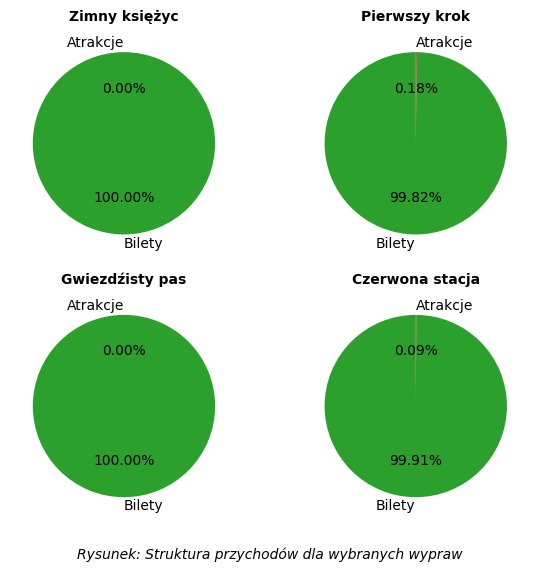

In [11]:
# Wybór wypraw do prezentacji (można zmienić na interesujące Cię)
wyprawy_do_pokazania = analiza.nlargest(6, 'przychod_calkowity_mln')['wyprawa_id']

# Tworzenie siatki wykresów
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

for ax, wyprawa_id in zip(axes.flatten(), wyprawy_do_pokazania):
    dane_wyprawy = analiza[analiza['wyprawa_id'] == wyprawa_id]
    rodzaj = dane_wyprawy['rodzaj_wyprawy'].values[0]
    
    bilety = dane_wyprawy['przychod_z_biletow_mln'].values[0]
    atrakcje = dane_wyprawy['przychod_z_atrakcji_mln'].values[0]
    
    if bilety + atrakcje > 0:  # tylko jeśli są jakieś przychody
        ax.pie([bilety, atrakcje],
               labels=['Bilety', 'Atrakcje'],
               autopct='%1.2f%%',
               colors=['#2ca02c', '#d62728'],
               startangle=90)
    
    ax.set_title(rodzaj, fontsize=10, fontweight='bold')

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.text(0.5, 0.01, "Rysunek: Struktura przychodów dla wybranych wypraw", ha='center', fontsize=10, style='italic')
plt.show()


In [12]:
def generuj_wnioski_struktura_top(analiza: pd.DataFrame) -> list:
    wnioski = []
    top6 = analiza.nlargest(6, 'przychod_calkowity_mln')

    wnioski.append("Wnioski – Struktura przychodów wybranych wypraw\n")

    # Sprawdzamy udział atrakcji w każdej z top6 wypraw
    udzialy_atrakcji = top6['przychod_z_atrakcji_mln'] / top6['przychod_calkowity_mln']
    udzialy_atrakcji = udzialy_atrakcji.fillna(0)  # na wszelki wypadek

    # Oceń czy atrakcje są w większości małe, umiarkowane, czy duże
    if all(udzialy_atrakcji < 0.01):
        wnioski.append("1. Bilety są zdecydowanie dominującym źródłem przychodów w każdej z analizowanych wypraw – udział atrakcji nie przekracza 1%.")
    elif all(udzialy_atrakcji < 0.1):
        wnioski.append("1. We wszystkich analizowanych wyprawach bilety stanowią główne źródło przychodów, jednak udział atrakcji jest zauważalny, lecz wciąż niewielki (poniżej 10%).")
    elif any(udzialy_atrakcji > 0.5):
        wnioski.append("1. W niektórych wyprawach udział przychodów z atrakcji jest bardzo wysoki, przekraczający 50%, co wskazuje na dużą popularność dodatkowych usług.")
    else:
        wnioski.append("1. Struktura przychodów jest zróżnicowana – w niektórych wyprawach dominują bilety, w innych znaczący udział mają atrakcje.")

    # Szczegóły dla każdej wyprawy
    for _, row in top6.iterrows():
        wyprawa = row['rodzaj_wyprawy']
        id_wyprawy = row['wyprawa_id']
        bilety = row['przychod_z_biletow_mln']
        atrakcje = row['przychod_z_atrakcji_mln']
        suma = row['przychod_calkowity_mln']
        udzial_atrakcji = 100 * atrakcje / suma if suma > 0 else 0

        if atrakcje == 0:
            wnioski.append(f"- Wyprawa \"{wyprawa}\" ({id_wyprawy}) osiągnęła 100% przychodów ze sprzedaży biletów, bez wpływów z atrakcji.")
        else:
            wnioski.append(f"- Wyprawa \"{wyprawa}\" ({id_wyprawy}) uzyskała {udzial_atrakcji:.2f}% przychodów z atrakcji, pozostałą część stanowiły bilety.")

    # Końcowy, dostosowany wniosek o potencjale
    sredni_udzial = udzialy_atrakcji.mean()
    if sredni_udzial < 0.05:
        wnioski.append("2. Niski średni udział atrakcji w przychodach sugeruje, że istnieje potencjał do rozwinięcia i promowania usług dodatkowych.")
    elif sredni_udzial < 0.3:
        wnioski.append("2. Średni udział atrakcji w przychodach jest umiarkowany – można rozważyć dalsze inwestycje w rozwój dodatkowych usług.")
    else:
        wnioski.append("2. Udział przychodów z atrakcji jest wysoki, co świadczy o dużej popularności i dobrym wykorzystaniu usług dodatkowych.")

    return wnioski



wnioski = generuj_wnioski_struktura_top(analiza)

# wnioski jest listą, więc wystarczy ją przekształcić do listy punktów markdown:
markdown_text = "\n".join(f"{line.strip()}" for line in wnioski if line.strip())

display(Markdown(markdown_text))


Wnioski – Struktura przychodów wybranych wypraw
1. Bilety są zdecydowanie dominującym źródłem przychodów w każdej z analizowanych wypraw – udział atrakcji nie przekracza 1%.
- Wyprawa "Zimny księżyc" (W12) osiągnęła 100% przychodów ze sprzedaży biletów, bez wpływów z atrakcji.
- Wyprawa "Pierwszy krok" (W04) uzyskała 0.18% przychodów z atrakcji, pozostałą część stanowiły bilety.
- Wyprawa "Gwiezdźisty pas" (W02) osiągnęła 100% przychodów ze sprzedaży biletów, bez wpływów z atrakcji.
- Wyprawa "Czerwona stacja" (W10) uzyskała 0.09% przychodów z atrakcji, pozostałą część stanowiły bilety.
- Wyprawa "Pierwszy krok" (W09) uzyskała 0.24% przychodów z atrakcji, pozostałą część stanowiły bilety.
- Wyprawa "W poszukiwaniu UFO" (W11) osiągnęła 100% przychodów ze sprzedaży biletów, bez wpływów z atrakcji.
2. Niski średni udział atrakcji w przychodach sugeruje, że istnieje potencjał do rozwinięcia i promowania usług dodatkowych.

- **Statystyki dla kosztów i zysków**

In [13]:

# Podsumowanie statystyk (mean, min, max)
podsumowanie = analiza.describe().loc[['mean', 'min', 'max']].T
md_podsumowanie = tabulate(podsumowanie, headers='keys', tablefmt='github', showindex=True)
display(Markdown(f"**Podsumowanie statystyk**\n\n{md_podsumowanie}"))

# Top 3 najbardziej dochodowe wyprawy
top_zysk = analiza.nlargest(3, 'zysk_brutto_mln')[['wyprawa_id', 'rodzaj_wyprawy', 'zysk_brutto_mln']]
md_top = tabulate(top_zysk, headers='keys', tablefmt='github', showindex=False)
display(Markdown(f"**Top 3 najbardziej dochodowe wyprawy**\n\n{md_top}"))

# Top 3 najmniej dochodowe wyprawy
bottom_zysk = analiza.nsmallest(3, 'zysk_brutto_mln')[['wyprawa_id', 'rodzaj_wyprawy', 'zysk_brutto_mln']]
md_bottom = tabulate(bottom_zysk, headers='keys', tablefmt='github', showindex=False)
display(Markdown(f"**Top 3 najmniej dochodowe wyprawy**\n\n{md_bottom}"))


**Podsumowanie statystyk**

|                         |        mean |     min |             max |
|-------------------------|-------------|---------|-----------------|
| koszt_mln               |     12.2769 |    2.05 |    23.73        |
| przychod_z_biletow_mln  |  17652.4    |    0    | 70845.3         |
| przychod_z_atrakcji_mln |     36.5838 |    0    |   166.24        |
| przychod_calkowity_mln  |  17689      |    0    | 70845.3         |
| zysk_brutto_mln         |  17676.7    |  -16.13 | 70836.7         |
| ROI                     | 343255      | -100    |     2.11152e+06 |
| marza                   |   -inf      | -inf    |   100           |

**Top 3 najbardziej dochodowe wyprawy**

| wyprawa_id   | rodzaj_wyprawy   |   zysk_brutto_mln |
|--------------|------------------|-------------------|
| W12          | Zimny księżyc    |           70836.7 |
| W04          | Pierwszy krok    |           48093.5 |
| W02          | Gwiezdźisty pas  |           43274.6 |

**Top 3 najmniej dochodowe wyprawy**

| wyprawa_id   | rodzaj_wyprawy     |   zysk_brutto_mln |
|--------------|--------------------|-------------------|
| W20          | Jak podbić księżyc |            -16.13 |
| W13          | Zimny księżyc      |             -7.17 |
| W07          | Gwiezdźisty pas    |             -6.7  |

In [14]:
import pandas as pd

def generuj_wnioski_podsumowanie(analiza: pd.DataFrame) -> list:
    wnioski = []
    
    # Statystyki opisowe
    stat = analiza.describe().T
    koszt_mean = stat.loc['koszt_mln', 'mean']
    koszt_min = stat.loc['koszt_mln', 'min']
    koszt_max = stat.loc['koszt_mln', 'max']
    
    bilety_mean = stat.loc['przychod_z_biletow_mln', 'mean']
    atrakcje_mean = stat.loc['przychod_z_atrakcji_mln', 'mean']
    przychod_max = stat.loc['przychod_calkowity_mln', 'max']
    
    zysk_max = stat.loc['zysk_brutto_mln', 'max']
    zysk_min = stat.loc['zysk_brutto_mln', 'min']
    
    roi_mean = stat.loc['ROI', 'mean']
    roi_min = stat.loc['ROI', 'min']
    
    wnioski.append(f"Średni koszt wyprawy wynosi około {koszt_mean:.2f} mln zł, przy czym najdroższa kosztowała niemal {koszt_max:.2f} mln zł, a najtańsza tylko {koszt_min:.2f} mln zł.")
    wnioski.append(f"Przychody z biletów znacznie przewyższają wpływy z atrakcji. Średni przychód z biletów to aż {bilety_mean:,.0f} mln zł, natomiast z atrakcji zaledwie {atrakcje_mean:.1f} mln zł.")
    wnioski.append(f"Wartość całkowitych przychodów wyprawy może sięgnąć nawet {przychod_max:,.2f} mln zł.")
    wnioski.append(f"Zysk brutto wyprawy może wynosić nawet {zysk_max:,.2f} mln zł, ale są też wyprawy generujące poważne straty – do {zysk_min:,.2f} mln zł.")
    wnioski.append(f"Średni ROI wynosi {roi_mean:,.1f}%, jednak może też osiągać wartości ujemne – nawet {roi_min:.0f}%.")

    # Top 3 najbardziej dochodowe
    top_zyski = analiza.nlargest(3, 'zysk_brutto_mln')
    wnioski.append("Top 3 najbardziej dochodowe wyprawy to:")
    for _, row in top_zyski.iterrows():
        wnioski.append(f"- {row['wyprawa_id']} – {row['rodzaj_wyprawy']}: zysk brutto {row['zysk_brutto_mln']:,.2f} mln zł")

    # Top 3 najmniej dochodowe
    bottom_zyski = analiza.nsmallest(3, 'zysk_brutto_mln')
    wnioski.append("Top 3 najmniej dochodowe wyprawy to:")
    for _, row in bottom_zyski.iterrows():
        wnioski.append(f"- {row['wyprawa_id']} – {row['rodzaj_wyprawy']}: strata {abs(row['zysk_brutto_mln']):,.2f} mln zł")

    return wnioski

wnioski = generuj_wnioski_podsumowanie(analiza)

markdown_text = "\n".join(f"{line.strip()}" for line in wnioski if line.strip())

display(Markdown(markdown_text))


Średni koszt wyprawy wynosi około 12.28 mln zł, przy czym najdroższa kosztowała niemal 23.73 mln zł, a najtańsza tylko 2.05 mln zł.
Przychody z biletów znacznie przewyższają wpływy z atrakcji. Średni przychód z biletów to aż 17,652 mln zł, natomiast z atrakcji zaledwie 36.6 mln zł.
Wartość całkowitych przychodów wyprawy może sięgnąć nawet 70,845.31 mln zł.
Zysk brutto wyprawy może wynosić nawet 70,836.69 mln zł, ale są też wyprawy generujące poważne straty – do -16.13 mln zł.
Średni ROI wynosi 343,254.6%, jednak może też osiągać wartości ujemne – nawet -100%.
Top 3 najbardziej dochodowe wyprawy to:
- W12 – Zimny księżyc: zysk brutto 70,836.69 mln zł
- W04 – Pierwszy krok: zysk brutto 48,093.46 mln zł
- W02 – Gwiezdźisty pas: zysk brutto 43,274.61 mln zł
Top 3 najmniej dochodowe wyprawy to:
- W20 – Jak podbić księżyc: strata 16.13 mln zł
- W13 – Zimny księżyc: strata 7.17 mln zł
- W07 – Gwiezdźisty pas: strata 6.70 mln zł

## Liczba obsłużonych klientów w każdym miesiącu

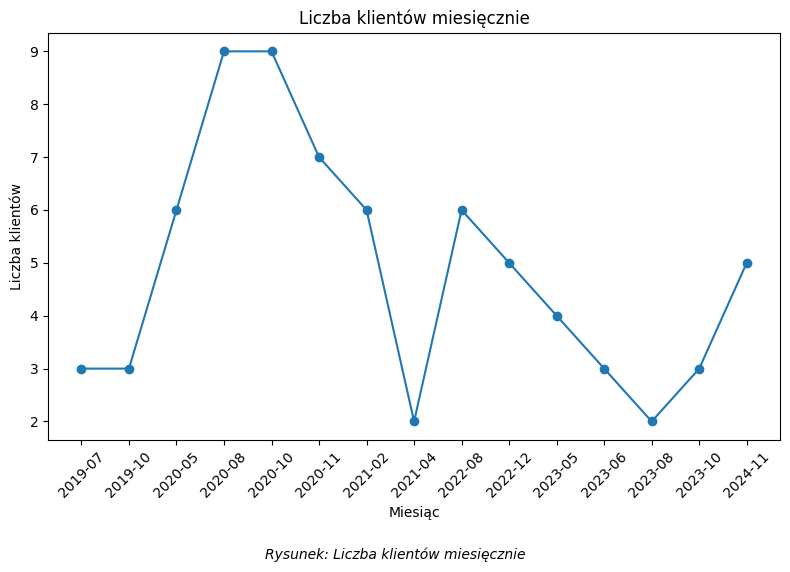

In [15]:
klienci_miesiac = pd.read_sql("""
SELECT DATE_FORMAT(w.data_startu, '%Y-%m') AS miesiac, 
        COUNT(DISTINCT uw.klient_id) AS liczba_klientow
FROM uczestnicy_wyprawy uw
JOIN wyprawy w ON w.wyprawa_id = uw.wyprawa_id
GROUP BY miesiac
ORDER BY miesiac
""", conn)


plt.figure(figsize=(8,6))
plt.plot(klienci_miesiac['miesiac'], klienci_miesiac['liczba_klientow'], marker='o')
plt.xticks(ticks=range(len(klienci_miesiac['miesiac'])), labels=klienci_miesiac['miesiac'], rotation=45)
plt.title("Liczba klientów miesięcznie")
plt.xlabel("Miesiąc")
plt.ylabel("Liczba klientów")

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.figtext(0.5, 0.01, "Rysunek: Liczba klientów miesięcznie", ha='center', fontsize=10, style='italic')

plt.show()


In [16]:
def generuj_wnioski_klienci(df: pd.DataFrame) -> list:
    wnioski = []
    
    df_sorted = df.sort_values('miesiac').reset_index(drop=True)

    max_row = df_sorted.loc[df_sorted['liczba_klientow'].idxmax()]
    wnioski.append(
        f"Największy skok liczby klientów wystąpił w {max_row['miesiac'].strftime('%m/%Y')} – "
        f"osiągnięto wtedy rekordowy poziom {int(max_row['liczba_klientow'])} klientów w jednym miesiącu."
    )

    idx = df_sorted['liczba_klientow'].idxmax()
    if idx + 1 < len(df_sorted):
        next_val = df_sorted.loc[idx + 1, 'liczba_klientow']
        if next_val < max_row['liczba_klientow'] / 2:
            spadek_miesiac = df_sorted.loc[idx + 1, 'miesiac'].strftime('%m/%Y')
            wnioski.append(
                f"Po {max_row['miesiac'].strftime('%m/%Y')} nastąpił gwałtowny spadek – "
                f"już w {spadek_miesiac} liczba klientów zmniejszyła się do zaledwie {int(next_val)}."
            )

    ostatnie_lata = df_sorted[df_sorted['miesiac'] >= pd.to_datetime("2022-01-01")]
    if not ostatnie_lata.empty:
        sr = ostatnie_lata['liczba_klientow'].mean()
        wnioski.append(
            f"W latach 2022–2023 obserwujemy stabilizację – miesięczna liczba klientów "
            f"utrzymuje się średnio na poziomie {sr:.1f}."
        )

    top3 = df_sorted.sort_values('liczba_klientow', ascending=False).head(3)
    if len(top3) >= 2:
        second_row = top3.iloc[1]
        wnioski.append(
            f"Kolejny wyraźny wzrost aktywności nastąpił w {second_row['miesiac'].strftime('%m/%Y')}, "
            f"osiągając poziom {int(second_row['liczba_klientow'])} klientów – to drugi najwyższy wynik w całym okresie."
        )

    ostatnie = df_sorted.tail(2)
    if not ostatnie.empty:
        sr_end = ostatnie['liczba_klientow'].mean()
        wnioski.append(
            f"Końcówka {ostatnie.iloc[-1]['miesiac'].year} roku cechuje się stabilną liczbą klientów "
            f"(około {sr_end:.1f}), co może sugerować ustabilizowany poziom zainteresowania ofertą."
        )

    return wnioski


# Przygotowanie danych i wyświetlenie
klienci_miesiac['miesiac'] = pd.to_datetime(klienci_miesiac['miesiac'])

wnioski = generuj_wnioski_klienci(klienci_miesiac)

markdown_text = "\n".join(f"* {line.strip()}" for line in wnioski if line.strip())

display(Markdown(markdown_text))


* Największy skok liczby klientów wystąpił w 08/2020 – osiągnięto wtedy rekordowy poziom 9 klientów w jednym miesiącu.
* W latach 2022–2023 obserwujemy stabilizację – miesięczna liczba klientów utrzymuje się średnio na poziomie 4.0.
* Kolejny wyraźny wzrost aktywności nastąpił w 10/2020, osiągając poziom 9 klientów – to drugi najwyższy wynik w całym okresie.
* Końcówka 2024 roku cechuje się stabilną liczbą klientów (około 4.0), co może sugerować ustabilizowany poziom zainteresowania ofertą.

## Klienci wracający i jednorazowi

In [17]:
# 1. Wczytanie danych o udziale klientów w wyprawach
uczestnictwo = pd.read_sql("""
SELECT 
    uw.klient_id,
    w.wyprawa_id,
    w.data_startu,
    r.nazwa AS rodzaj_wyprawy
FROM uczestnicy_wyprawy uw
JOIN wyprawy w ON uw.wyprawa_id = w.wyprawa_id
JOIN rodzaje_wypraw r ON w.rodzaj_wyprawy_id = r.rodzaj_wyprawy_id
ORDER BY uw.klient_id, w.data_startu
""", conn)

# 2. Czy klient wrócił (czy był na więcej niż jednej wyprawie)?
powroty = uczestnictwo.groupby('klient_id').size().reset_index(name='ilosc_wypraw')
powroty['czy_powrocil'] = powroty['ilosc_wypraw'] > 1

# 3. Czy klient wrócił na ten sam rodzaj wyprawy?
same_type_return = uczestnictwo.groupby(['klient_id', 'rodzaj_wyprawy']).size().reset_index(name='liczba_razem')
powrot_na_ta_sama = same_type_return[same_type_return['liczba_razem'] > 1].groupby('klient_id').size().reset_index(name='powtorzenia_typu')
powrot_na_ta_sama['czy_na_ta_sama'] = True

# 4. Średni czas między wyprawami (dla klientów z min 2)
uczestnictwo['data_startu'] = pd.to_datetime(uczestnictwo['data_startu'])

def format_duration(td):
    days = td.days
    months = days // 30
    days_left = days % 30
    parts = []
    if months > 0:
        parts.append(f"{months} {'miesiąc' if months == 1 else 'miesięcy'}")
    if days_left > 0:
        parts.append(f"{days_left} {'dzień' if days_left == 1 else 'dni'}")
    return " ".join(parts) if parts else "brak"

roznice = (
    uczestnictwo
    .groupby('klient_id')['data_startu']
    .apply(lambda x: format_duration(x.sort_values().diff().dropna().mean()))
    .reset_index(name='sredni_czas_miedzy_wyprawami')
)

# 5. Łączenie w jedną ramkę
analiza_lojalnosci = powroty.merge(powrot_na_ta_sama[['klient_id', 'czy_na_ta_sama']], on='klient_id', how='left')
analiza_lojalnosci = analiza_lojalnosci.merge(roznice, on='klient_id', how='left')
analiza_lojalnosci['czy_na_ta_sama'] = analiza_lojalnosci['czy_na_ta_sama'].fillna(False)

md_table = tabulate(analiza_lojalnosci, headers='keys', tablefmt='github', showindex=False)
display(Markdown(f"**Analiza lojalności klientów**\n\n{md_table}"))

**Analiza lojalności klientów**

|   klient_id |   ilosc_wypraw | czy_powrocil   | czy_na_ta_sama   | sredni_czas_miedzy_wyprawami   |
|-------------|----------------|----------------|------------------|--------------------------------|
|           1 |              2 | True           | False            | 8 miesięcy 17 dni              |
|           2 |              2 | True           | False            | 2 miesięcy 9 dni               |
|           3 |              2 | True           | False            | 26 miesięcy 21 dni             |
|           4 |              3 | True           | False            | 12 miesięcy 15 dni             |
|           5 |              2 | True           | False            | 6 miesięcy 25 dni              |
|           6 |              3 | True           | False            | 17 miesięcy 12 dni             |
|           7 |              3 | True           | False            | 24 miesięcy 24 dni             |
|           8 |              2 | True           | False            | 31 miesięcy 15 dni             |
|           9 |              3 | True           | False            | 19 miesięcy 22 dni             |
|          10 |              2 | True           | False            | 4 miesięcy 14 dni              |
|          11 |              2 | True           | False            | 33 miesięcy 18 dni             |
|          12 |              3 | True           | False            | 5 miesięcy 9 dni               |
|          13 |              3 | True           | True             | 24 miesięcy 5 dni              |
|          14 |              3 | True           | False            | 17 miesięcy                    |
|          15 |              3 | True           | False            | 1 miesiąc 4 dni                |
|          16 |              2 | True           | False            | 49 miesięcy 19 dni             |
|          17 |              2 | True           | False            | 22 miesięcy 5 dni              |
|          18 |              2 | True           | False            | 54 miesięcy 15 dni             |
|          19 |              2 | True           | False            | 35 miesięcy 14 dni             |
|          20 |              3 | True           | False            | 16 miesięcy 12 dni             |
|          21 |              2 | True           | False            | 37 miesięcy 23 dni             |
|          22 |              2 | True           | False            | 22 miesięcy 5 dni              |
|          23 |              2 | True           | False            | 1 miesiąc 6 dni                |
|          24 |              3 | True           | True             | 4 miesięcy 20 dni              |
|          25 |              3 | True           | True             | 4 miesięcy 29 dni              |
|          26 |              1 | False          | False            | brak                           |
|          27 |              3 | True           | True             | 3 miesięcy 8 dni               |
|          28 |              3 | True           | False            | 21 miesięcy 12 dni             |
|          29 |              3 | True           | False            | 18 miesięcy 6 dni              |
|          30 |              3 | True           | False            | 17 miesięcy 9 dni              |

In [18]:
def generuj_wnioski_lojalnosc(df: pd.DataFrame) -> list:
    wnioski = []

    # Liczba klientów
    liczba_klientow = df.shape[0]
    liczba_powracajacych = df['czy_powrocil'].sum()
    liczba_tych_samych = df['czy_na_ta_sama'].sum()

    # Wnioski o powrotach
    if liczba_powracajacych == liczba_klientow:
        wnioski.append("Wszyscy klienci, którzy wzięli udział w więcej niż jednej wyprawie, powrócili.")
    else:
        wnioski.append(f"{liczba_powracajacych} z {liczba_klientow} klientów powróciło co najmniej raz.")

    # Wnioski o tej samej wyprawie
    wnioski.append(f"{liczba_tych_samych} klientów wróciło na ten sam rodzaj wyprawy, co może świadczyć o jego dużej atrakcyjności.")

    # Średni czas między wyprawami – zakładamy, że kolumna jest tekstowa np. "47 miesięcy 3 dni"
    try:
        # Wyciąganie liczby miesięcy jako liczby zmiennoprzecinkowej
        df['sredni_czas_mies'] = df['sredni_czas_miedzy_wyprawami'].str.extract(r'(\d+)').astype(float)
        srednia_miesiecy = df['sredni_czas_mies'].mean()
        wnioski.append(f"Średni czas między wyprawami wynosi około {srednia_miesiecy:.1f} miesięcy.")
    except Exception as e:
        wnioski.append("Nie udało się przeliczyć średniego czasu między wyprawami na liczbę miesięcy.")

    # Najkrótszy i najdłuższy czas między wyprawami
    try:
        df_valid = df[df['sredni_czas_mies'].notna()]
        najkrotszy = df_valid.loc[df_valid['sredni_czas_mies'].idxmin()]
        najdluzszy = df_valid.loc[df_valid['sredni_czas_mies'].idxmax()]
        wnioski.append(
            f"Najkrótszy czas między wyprawami to {najkrotszy['sredni_czas_miedzy_wyprawami']} (klient {najkrotszy['klient_id']}), "
            f"najdłuższy – {najdluzszy['sredni_czas_miedzy_wyprawami']} (klient {najdluzszy['klient_id']})."
        )
    except Exception as e:
        wnioski.append("Nie udało się określić klientów z najkrótszym i najdłuższym czasem między wyprawami.")

    return wnioski

wnioski = generuj_wnioski_lojalnosc(analiza_lojalnosci)

markdown_text = "\n".join(f"* {line.strip()}" for line in wnioski if line.strip())

display(Markdown(markdown_text))

* 29 z 30 klientów powróciło co najmniej raz.
* 4 klientów wróciło na ten sam rodzaj wyprawy, co może świadczyć o jego dużej atrakcyjności.
* Średni czas między wyprawami wynosi około 18.3 miesięcy.
* Najkrótszy czas między wyprawami to 1 miesiąc 4 dni (klient 15), najdłuższy – 54 miesięcy 15 dni (klient 18).

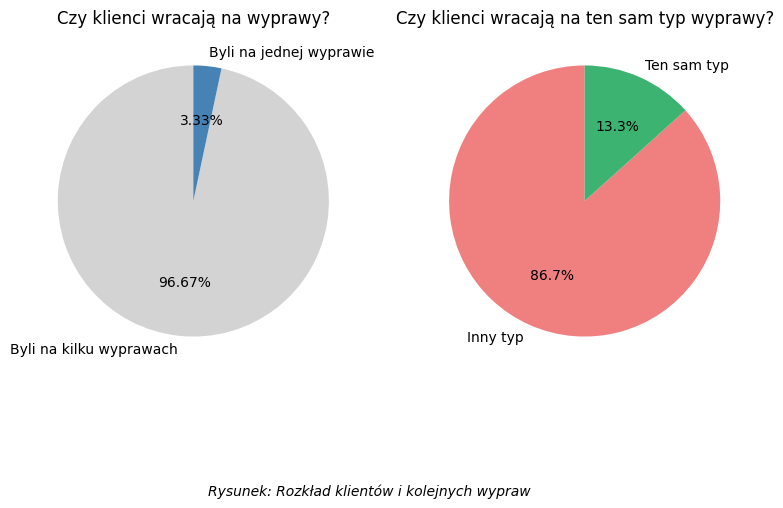

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

# Wykres 1: Czy klienci wracają?
axs[0].pie(
    analiza_lojalnosci['czy_powrocil'].value_counts(), 
    labels=['Byli na kilku wyprawach', 'Byli na jednej wyprawie'], 
    autopct='%1.2f%%', 
    colors=['lightgray', 'steelblue'], 
    startangle=90
)
axs[0].set_title('Czy klienci wracają na wyprawy?')

# Wykres 2: Czy wracają na ten sam typ wyprawy?
axs[1].pie(
    analiza_lojalnosci['czy_na_ta_sama'].value_counts(), 
    labels=['Inny typ', 'Ten sam typ'], 
    autopct='%1.1f%%', 
    colors=['lightcoral', 'mediumseagreen'], 
    startangle=90
)
axs[1].set_title('Czy klienci wracają na ten sam typ wyprawy?')

plt.tight_layout()

# Dodanie podpisu pod wykresami (na dole, wyśrodkowany)
fig.text(0.5, 0.01, "Rysunek: Rozkład klientów i kolejnych wypraw", ha='center', fontsize=10, style='italic')

plt.show()


In [20]:
def generuj_wnioski_lojalnosci(df: pd.DataFrame) -> list:
    wnioski = []

    liczba_klientow = len(df)
    liczba_powracajacych = df['ilosc_wypraw'].gt(1).sum()
    procent_powrotow = 100 * liczba_powracajacych / liczba_klientow

    wnioski.append(
        f"Zdecydowana większość klientów ({procent_powrotow:.2f}%) uczestniczyła w więcej niż jednej wyprawie, "
        f"co świadczy o wysokim poziomie lojalności klientów wobec oferty."
    )

    df_powracajacy = df[df['ilosc_wypraw'] > 1]
    liczba_ten_sam_typ = df_powracajacy['czy_na_ta_sama'].sum()
    procent_ten_sam_typ = 100 * liczba_ten_sam_typ / len(df_powracajacy)
    procent_inny_typ = 100 - procent_ten_sam_typ

    wnioski.append(
        f"Spośród klientów, którzy powrócili: "
        f"{procent_ten_sam_typ:.1f}% wróciło na ten sam typ wyprawy, "
        f"a {procent_inny_typ:.1f}% wybrało inny typ, co sugeruje różnorodność zainteresowań i atrakcyjność całej oferty."
    )

    return wnioski

wnioski = generuj_wnioski_lojalnosci(analiza_lojalnosci)

markdown_text = "\n".join(f"* {line.strip()}" for line in wnioski if line.strip())

display(Markdown(markdown_text))

* Zdecydowana większość klientów (96.67%) uczestniczyła w więcej niż jednej wyprawie, co świadczy o wysokim poziomie lojalności klientów wobec oferty.
* Spośród klientów, którzy powrócili: 13.8% wróciło na ten sam typ wyprawy, a 86.2% wybrało inny typ, co sugeruje różnorodność zainteresowań i atrakcyjność całej oferty.

## Jakie typy wypraw generują najwięcej transakcji dodatkowych? Czy dodatkowe przychody są znaczące?

In [22]:
query = """
SELECT
    rw.rodzaj_wyprawy_id,
    rw.nazwa,
    COUNT(CASE WHEN t.czy_dod_atrakcja = 'Tak' THEN 1 END) AS liczba_dodatkowych_atrakcji,
    SUM(CASE WHEN t.czy_dod_atrakcja = 'Tak' THEN t.kwota_atrakcji ELSE 0 END) AS laczna_kwota_atrakcji,
    COUNT(CASE WHEN t.czy_dod_atrakcja = 'Tak' THEN t.transakcja_id END) AS liczba_transakcji_z_atrakcja,
    SUM(t.kwota_za_wyprawe_mln) AS laczna_kwota_wypraw_mln

FROM transakcje t
JOIN wyprawy w ON t.wyprawa_id = w.wyprawa_id
JOIN rodzaje_wypraw rw ON w.rodzaj_wyprawy_id = rw.rodzaj_wyprawy_id
GROUP BY rw.rodzaj_wyprawy_id, rw.nazwa
ORDER BY liczba_dodatkowych_atrakcji DESC;
"""

df = pd.read_sql(query, conn)

df['laczna_kwota_atrakcji_zl'] = df['laczna_kwota_atrakcji'] * 1_000
df['laczna_kwota_wypraw_zl'] = df['laczna_kwota_wypraw_mln'] * 1_000_000

df['przychod_calkowity_zl'] = df['laczna_kwota_atrakcji_zl'] + df['laczna_kwota_wypraw_zl']
df['przychod_calkowity_mln_zl'] = (df['laczna_kwota_atrakcji_zl'] + df['laczna_kwota_wypraw_zl']) / 1_000_000


df['udzial_atrakcji_w_przychodzie_proc'] = (
    df['laczna_kwota_atrakcji_zl']  / df['przychod_calkowity_zl'] 
) * 100

# Konwersja kolumn na format liczbowy bez notacji wykładniczej
df_display = df.copy()

# Formatowanie kolumn z kwotami i udziałem
for col in ['laczna_kwota_atrakcji_zl', 'przychod_calkowity_mln_zl', 'udzial_atrakcji_w_przychodzie_proc']:
    if col in df_display.columns:
        df_display[col] = df_display[col].apply(lambda x: f"{x:.0f}")

# Tworzymy markdownową tabelę
md_table = tabulate(
    df_display[['nazwa', 'liczba_dodatkowych_atrakcji', 'laczna_kwota_atrakcji_zl', 
                'przychod_calkowity_mln_zl', 'udzial_atrakcji_w_przychodzie_proc']],
    headers='keys', tablefmt='github', showindex=False
)

display(Markdown(f"**Podsumowanie przychodów z dodatkowych atrakcji**\n\n{md_table}"))



**Podsumowanie przychodów z dodatkowych atrakcji**

| nazwa              |   liczba_dodatkowych_atrakcji |   laczna_kwota_atrakcji_zl |   przychod_calkowity_mln_zl |   udzial_atrakcji_w_przychodzie_proc |
|--------------------|-------------------------------|----------------------------|-----------------------------|--------------------------------------|
| Pierwszy krok      |                             5 |                  216050000 |                       96236 |                                    0 |
| Oko Ziemi          |                             4 |                   96200000 |                         669 |                                   14 |
| Orbitalny weekend  |                             4 |                  166240000 |                         681 |                                   24 |
| Jak podbić księżyc |                             2 |                   53360000 |                        1822 |                                    3 |
| Czerwona stacja    |                             1 |                   33110000 |                       37967 |                                    0 |
| Misja na księżyc   |                             1 |                   20380000 |                        1000 |                                    2 |
| Zimny księżyc      |                             0 |                          0 |                       70845 |                                    0 |
| W poszukiwaniu UFO |                             0 |                          0 |                       30527 |                                    0 |
| Gwiezdźisty pas    |                             0 |                          0 |                       43277 |                                    0 |

In [23]:
def generuj_wnioski_atrakcje(df):
    wnioski = []

    # Największy udział atrakcji
    top_udzial = df.loc[df['udzial_atrakcji_w_przychodzie_proc'].idxmax()]
    if top_udzial['udzial_atrakcji_w_przychodzie_proc'] > 0:
        wnioski.append(
            f"Wyprawa \"{top_udzial['nazwa']}\" miała najwyższy udział przychodów z atrakcji – "
            f"{top_udzial['udzial_atrakcji_w_przychodzie_proc']:.2f}%."
        )

    # Największa wartość przychodów z atrakcji
    top_kwota = df.loc[df['laczna_kwota_atrakcji_zl'].idxmax()]
    if top_kwota['laczna_kwota_atrakcji_zl'] > 0:
        wnioski.append(
            f"Największą wartość przychodów z atrakcji osiągnięto w wyprawie \"{top_kwota['nazwa']}\", "
            f"z kwotą {top_kwota['laczna_kwota_atrakcji_zl'] / 1_000_000:.1f} mln zł."
        )

    # Brak przychodów z atrakcji
    brak = df[df['laczna_kwota_atrakcji_zl'] == 0]
    for _, row in brak.iterrows():
        wnioski.append(
            f"Wyprawa \"{row['nazwa']}\" nie wygenerowała żadnych przychodów z atrakcji."
        )

    # Niski udział atrakcji mimo dużych przychodów
    prog = 0.5  # próg procentowy uznawany za niski udział
    wysokie_przychody = df[df['przychod_calkowity_mln_zl'] > df['przychod_calkowity_mln_zl'].median()]
    niskie_udzialy = wysokie_przychody[wysokie_przychody['udzial_atrakcji_w_przychodzie_proc'] < prog]
    for _, row in niskie_udzialy.iterrows():
        wnioski.append(
            f"Mimo wysokich przychodów ({row['przychod_calkowity_mln_zl']:.0f} mln zł), wyprawa "
            f"\"{row['nazwa']}\" miała bardzo niski udział atrakcji ({row['udzial_atrakcji_w_przychodzie_proc']:.2f}%)."
        )

    return wnioski

# Przykład użycia:
wnioski = generuj_wnioski_atrakcje(df)  # zakładamy, że `dane_atrakcje` to DataFrame ze zrzutu

markdown_text = "\n".join(f"* {line.strip()}" for line in wnioski if line.strip())

display(Markdown(markdown_text))

* Wyprawa "Orbitalny weekend" miała najwyższy udział przychodów z atrakcji – 24.40%.
* Największą wartość przychodów z atrakcji osiągnięto w wyprawie "Pierwszy krok", z kwotą 216.1 mln zł.
* Wyprawa "Zimny księżyc" nie wygenerowała żadnych przychodów z atrakcji.
* Wyprawa "W poszukiwaniu UFO" nie wygenerowała żadnych przychodów z atrakcji.
* Wyprawa "Gwiezdźisty pas" nie wygenerowała żadnych przychodów z atrakcji.
* Mimo wysokich przychodów (96236 mln zł), wyprawa "Pierwszy krok" miała bardzo niski udział atrakcji (0.22%).
* Mimo wysokich przychodów (37967 mln zł), wyprawa "Czerwona stacja" miała bardzo niski udział atrakcji (0.09%).
* Mimo wysokich przychodów (70845 mln zł), wyprawa "Zimny księżyc" miała bardzo niski udział atrakcji (0.00%).
* Mimo wysokich przychodów (43277 mln zł), wyprawa "Gwiezdźisty pas" miała bardzo niski udział atrakcji (0.00%).

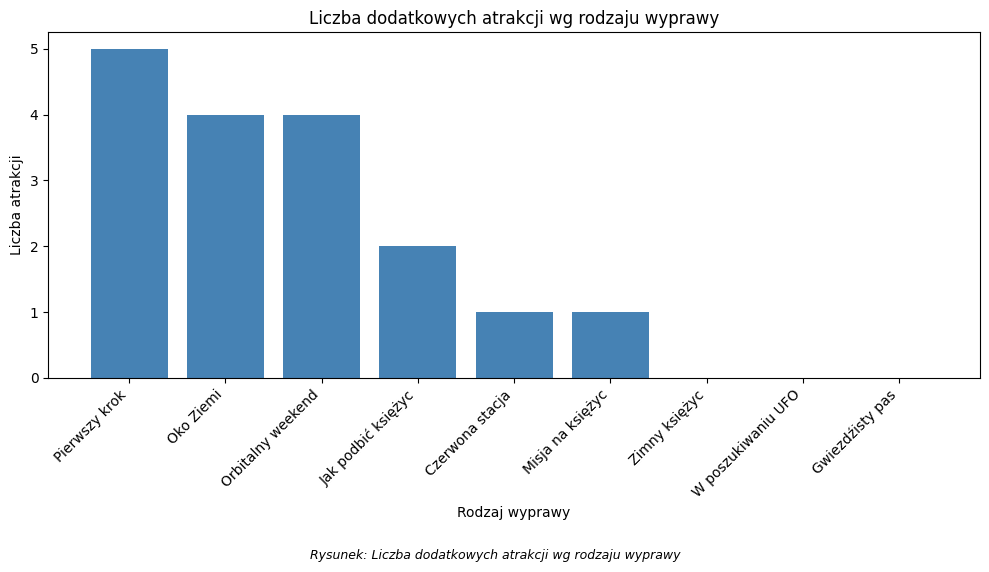

In [24]:
plt.figure(figsize=(10, 6))
plt.bar(df['nazwa'], df['liczba_dodatkowych_atrakcji'], color='steelblue')
plt.title('Liczba dodatkowych atrakcji wg rodzaju wyprawy')
plt.xlabel('Rodzaj wyprawy')
plt.ylabel('Liczba atrakcji')
plt.xticks(rotation=45, ha='right')
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.figtext(0.5, 0.01, "Rysunek: Liczba dodatkowych atrakcji wg rodzaju wyprawy", ha='center', fontsize=9, style='italic')

plt.show()

In [25]:
def generuj_wnioski_liczba_atrakcji(df):
    wnioski = []

    # Najwięcej atrakcji
    top = df.loc[df['liczba_dodatkowych_atrakcji'].idxmax()]
    wnioski.append(
        f"Wyprawa \"{top['nazwa']}\" oferowała najwięcej dodatkowych atrakcji – aż {top['liczba_dodatkowych_atrakcji']}."
    )

    # Wyprawy bez dodatkowych atrakcji
    bez_atrakcji = df[df['liczba_dodatkowych_atrakcji'] == 0]
    for _, row in bez_atrakcji.iterrows():
        wnioski.append(
            f"Wyprawa \"{row['nazwa']}\" nie oferowała żadnych dodatkowych atrakcji."
        )

    # Wyprawy z minimalną ofertą
    minimalne = df[df['liczba_dodatkowych_atrakcji'] <= 1]
    for _, row in minimalne.iterrows():
        if row['liczba_dodatkowych_atrakcji'] > 0:
            wnioski.append(
                f"Wyprawa \"{row['nazwa']}\" miała bardzo ograniczoną ofertę – tylko {row['liczba_dodatkowych_atrakcji']} atrakcję."
            )

    return wnioski

# Przykład użycia:
wnioski = generuj_wnioski_liczba_atrakcji(df)

markdown_text = "\n".join(f"* {line.strip()}" for line in wnioski if line.strip())

display(Markdown(markdown_text))

* Wyprawa "Pierwszy krok" oferowała najwięcej dodatkowych atrakcji – aż 5.
* Wyprawa "Zimny księżyc" nie oferowała żadnych dodatkowych atrakcji.
* Wyprawa "W poszukiwaniu UFO" nie oferowała żadnych dodatkowych atrakcji.
* Wyprawa "Gwiezdźisty pas" nie oferowała żadnych dodatkowych atrakcji.
* Wyprawa "Czerwona stacja" miała bardzo ograniczoną ofertę – tylko 1 atrakcję.
* Wyprawa "Misja na księżyc" miała bardzo ograniczoną ofertę – tylko 1 atrakcję.

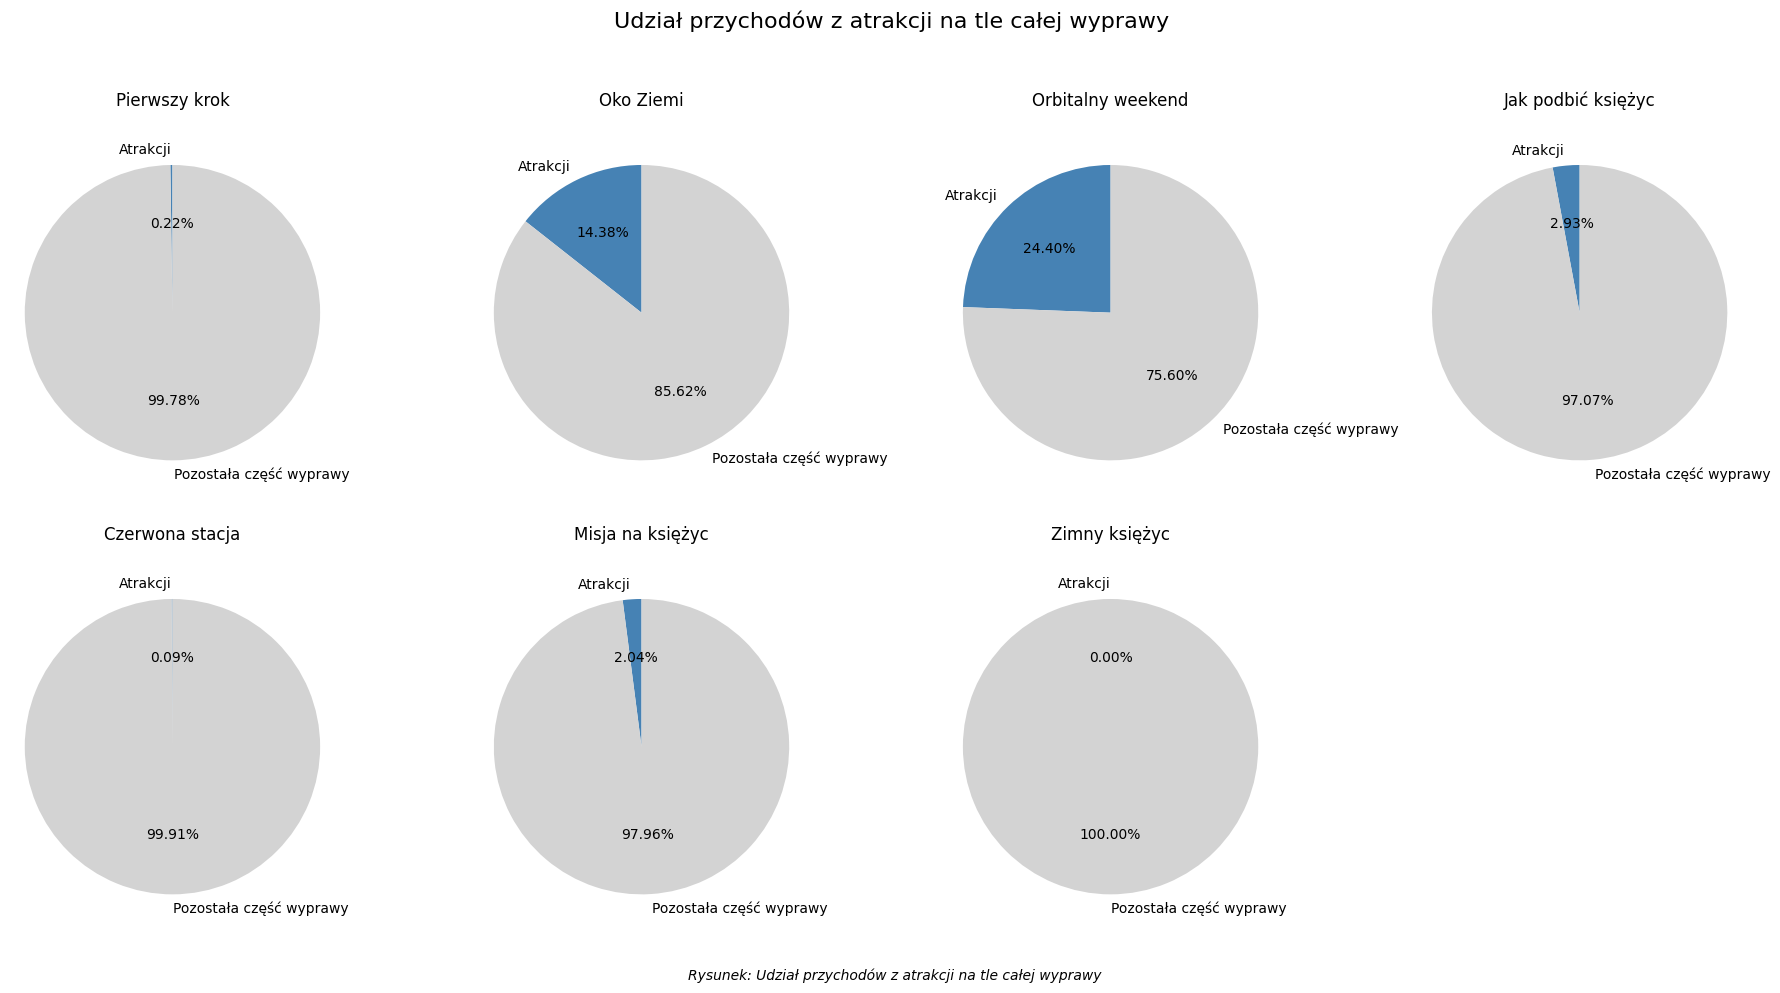

In [26]:
top7 = df.sort_values(by='liczba_dodatkowych_atrakcji', ascending=False).head(7)

fig, axes = plt.subplots(2, 4, figsize=(18, 10))  
axes = axes.flatten()

for i, (_, row) in enumerate(top7.iterrows()):
    labels = ['Atrakcji', 'Pozostała część wyprawy']
    wartosci = [
        row['laczna_kwota_atrakcji_zl'],
        row['laczna_kwota_wypraw_zl']
    ]
    colors = ['steelblue', 'lightgray']
    
    axes[i].pie(wartosci, labels=labels, autopct='%1.2f%%', colors=colors, startangle=90)
    axes[i].axis('equal')
    axes[i].set_title(f"{row['nazwa']}")

for j in range(len(top7), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Udział przychodów z atrakcji na tle całej wyprawy ', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.text(0.5, 0.01, "Rysunek: Udział przychodów z atrakcji na tle całej wyprawy", ha='center', fontsize=10, style='italic')
plt.show()

In [27]:
def generuj_wnioski_udzial_atrakcji(df):
    wnioski = []

    # Wyprawa z największym udziałem atrakcji
    top = df.loc[df['udzial_atrakcji_w_przychodzie_proc'].idxmax()]
    if top['udzial_atrakcji_w_przychodzie_proc'] > 0:
        wnioski.append(
            f"Wyprawa \"{top['nazwa']}\" miała największy udział przychodów z atrakcji – "
            f"{top['udzial_atrakcji_w_przychodzie_proc']:.2f}%."
        )

    # Wyprawy bez przychodu z atrakcji
    bez_atrakcji = df[df['udzial_atrakcji_w_przychodzie_proc'] == 0]
    for _, row in bez_atrakcji.iterrows():
        wnioski.append(
            f"Wyprawa \"{row['nazwa']}\" nie generowała żadnych przychodów z atrakcji."
        )

    # Wyprawy z marginalnym udziałem atrakcji (< 1%)
    marginalne = df[(df['udzial_atrakcji_w_przychodzie_proc'] > 0) & 
                    (df['udzial_atrakcji_w_przychodzie_proc'] < 1)]
    for _, row in marginalne.iterrows():
        wnioski.append(
            f"Wyprawa \"{row['nazwa']}\" miała marginalny udział przychodów z atrakcji – "
            f"{row['udzial_atrakcji_w_przychodzie_proc']:.2f}%."
        )

    return wnioski

# Przykład użycia:
wnioski = generuj_wnioski_udzial_atrakcji(df)

markdown_text = "\n".join(f"* {line.strip()}" for line in wnioski if line.strip())

display(Markdown(markdown_text))


* Wyprawa "Orbitalny weekend" miała największy udział przychodów z atrakcji – 24.40%.
* Wyprawa "Zimny księżyc" nie generowała żadnych przychodów z atrakcji.
* Wyprawa "W poszukiwaniu UFO" nie generowała żadnych przychodów z atrakcji.
* Wyprawa "Gwiezdźisty pas" nie generowała żadnych przychodów z atrakcji.
* Wyprawa "Pierwszy krok" miała marginalny udział przychodów z atrakcji – 0.22%.
* Wyprawa "Czerwona stacja" miała marginalny udział przychodów z atrakcji – 0.09%.

## Czy pojazdy wykorzystywane w wyprawach są równomiernie eksploatowane? Czy niektóre są nadmiernie obciążane lub niewykorzystywane?

In [28]:
query = """
SELECT 
    p.pojazd_id,
    p.nazwa,
    COUNT(w.wyprawa_id) AS liczba_wypraw
FROM pojazdy p
LEFT JOIN wyprawy w ON p.pojazd_id = w.pojazd_id
GROUP BY p.pojazd_id, p.nazwa
ORDER BY liczba_wypraw DESC;
"""

df = pd.read_sql(query, conn)

tabela = "Pojazdy według liczby wypraw"

md_table = tabulate(df.head(10), headers='keys', tablefmt='github', showindex=False)
display(Markdown(f"**{tabela}**\n\n{md_table}"))

**Pojazdy według liczby wypraw**

| pojazd_id   | nazwa      |   liczba_wypraw |
|-------------|------------|-----------------|
| Pojazd_1    | UIR02HB    |               4 |
| Pojazd_2    | VBIY-B     |               4 |
| Pojazd_3    | T-4OL5G8KZ |               4 |
| Pojazd_4    | 2SNX94WI-M |               4 |
| Pojazd_5    | K2QUQB9Z   |               0 |

In [29]:
def generuj_wnioski_pojazdy(df):
    wnioski = []

    # Pojazdy z największą liczbą wypraw
    max_wypraw = df['liczba_wypraw'].max()
    pojazdy_max = df[df['liczba_wypraw'] == max_wypraw]

    if not pojazdy_max.empty:
        for _, row in pojazdy_max.iterrows():
            wnioski.append(
                f"Pojazd \"{row['nazwa']}\" był jednym z najczęściej używanych – odbył {row['liczba_wypraw']} wypraw."
            )

    # Pojazdy niewykorzystane
    niewykorzystane = df[df['liczba_wypraw'] == 0]
    for _, row in niewykorzystane.iterrows():
        wnioski.append(
            f"Pojazd \"{row['nazwa']}\" nie został jeszcze wykorzystany w żadnej wyprawie."
        )

    return wnioski

# Przykład użycia:
wnioski = generuj_wnioski_pojazdy(df)
markdown_text = "\n".join(f"* {line.strip()}" for line in wnioski if line.strip())

display(Markdown(markdown_text))

* Pojazd "UIR02HB" był jednym z najczęściej używanych – odbył 4 wypraw.
* Pojazd "VBIY-B" był jednym z najczęściej używanych – odbył 4 wypraw.
* Pojazd "T-4OL5G8KZ" był jednym z najczęściej używanych – odbył 4 wypraw.
* Pojazd "2SNX94WI-M" był jednym z najczęściej używanych – odbył 4 wypraw.
* Pojazd "K2QUQB9Z" nie został jeszcze wykorzystany w żadnej wyprawie.

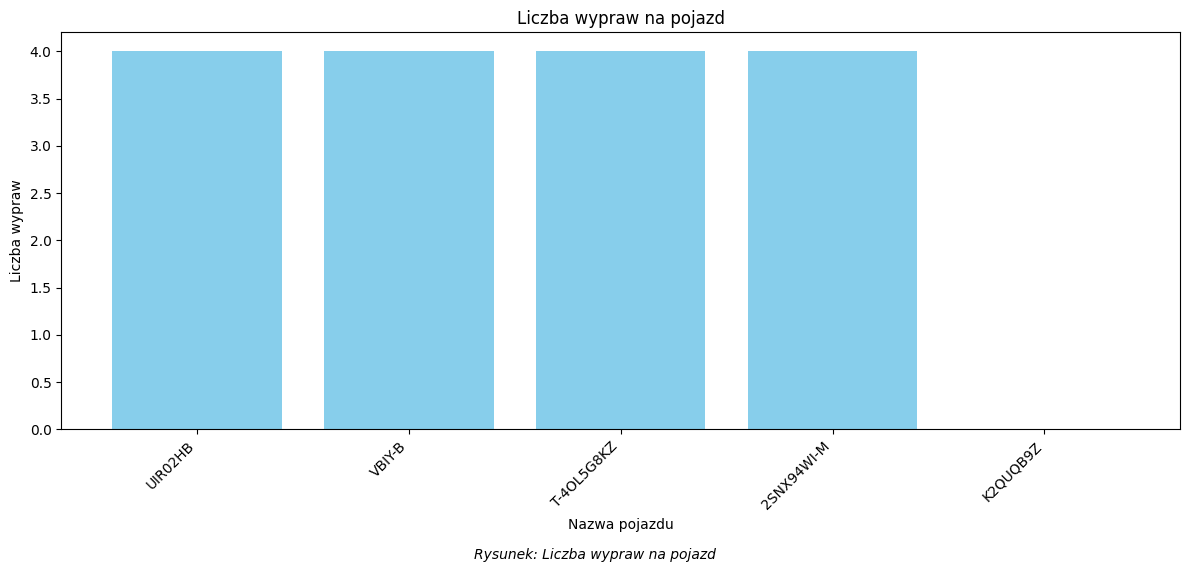

In [30]:
plt.figure(figsize=(12, 6))
plt.bar(df['nazwa'], df['liczba_wypraw'], color='skyblue')
plt.title('Liczba wypraw na pojazd')
plt.xlabel('Nazwa pojazdu')
plt.ylabel('Liczba wypraw')
plt.xticks(rotation=45, ha='right')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.figtext(0.5, 0.01, "Rysunek: Liczba wypraw na pojazd", ha='center', fontsize=10, style='italic')
plt.show()


In [31]:
def generuj_wnioski_pojazdy_wykres(df):
    wnioski = []

    # Najczęściej używane pojazdy
    max_liczba = df['liczba_wypraw'].max()
    top = df[df['liczba_wypraw'] == max_liczba]

    if not top.empty:
        top_names = ", ".join(top['nazwa'].tolist())
        wnioski.append(
            f"Pojazdy {top_names} były najczęściej używane – każdy odbył {max_liczba} wypraw."
        )

    # Pojazdy nieużywane
    unused = df[df['liczba_wypraw'] == 0]
    for _, row in unused.iterrows():
        wnioski.append(
            f"Pojazd {row['nazwa']} nie został jeszcze użyty w żadnej wyprawie."
        )

    return wnioski

# Przykład użycia:
wnioski = generuj_wnioski_pojazdy_wykres(df)

markdown_text = "\n".join(f"* {line.strip()}" for line in wnioski if line.strip())

display(Markdown(markdown_text))

* Pojazdy UIR02HB, VBIY-B, T-4OL5G8KZ, 2SNX94WI-M były najczęściej używane – każdy odbył 4 wypraw.
* Pojazd K2QUQB9Z nie został jeszcze użyty w żadnej wyprawie.

In [32]:
query = """
SELECT 
    p.pojazd_id,
    p.nazwa AS nazwa_pojazdu,
    w.rodzaj_wyprawy_id,
    COUNT(w.wyprawa_id) AS liczba_wypraw_na_trasie
FROM pojazdy p
LEFT JOIN wyprawy w ON p.pojazd_id = w.pojazd_id
GROUP BY p.pojazd_id, p.nazwa, w.rodzaj_wyprawy_id
ORDER BY p.pojazd_id, liczba_wypraw_na_trasie DESC;
"""

df = pd.read_sql(query, conn)

wszystkie_pojazdy = df[['pojazd_id', 'nazwa_pojazdu']].drop_duplicates()

pivot = df.pivot_table(
    columns='pojazd_id',
    index='rodzaj_wyprawy_id',
    values='liczba_wypraw_na_trasie',
    fill_value=0
)

for pid in wszystkie_pojazdy['pojazd_id']:
    if pid not in pivot.columns:
        pivot[pid] = 0

pivot = pivot[sorted(pivot.columns)]


tabela = "Liczba wypraw dla każdego pojazdu wg rodzaju wyprawy:"

md_table = tabulate(pivot, headers='keys', tablefmt='github', showindex=True)
display(Markdown(f"**{tabela}**\n\n{md_table}"))


**Liczba wypraw dla każdego pojazdu wg rodzaju wyprawy:**

| rodzaj_wyprawy_id   |   Pojazd_1 |   Pojazd_2 |   Pojazd_3 |   Pojazd_4 |   Pojazd_5 |
|---------------------|------------|------------|------------|------------|------------|
| R01                 |          1 |          0 |          0 |          0 |          0 |
| R02                 |          0 |          0 |          0 |          1 |          0 |
| R03                 |          1 |          1 |          0 |          1 |          0 |
| R04                 |          1 |          1 |          0 |          1 |          0 |
| R05                 |          0 |          1 |          0 |          0 |          0 |
| R06                 |          0 |          0 |          1 |          0 |          0 |
| R07                 |          0 |          1 |          1 |          0 |          0 |
| R08                 |          0 |          0 |          2 |          0 |          0 |
| R09                 |          1 |          0 |          0 |          1 |          0 |

In [33]:
def generuj_wnioski_rozklad_wypraw(pivot):
    wnioski = []

    suma_rodzajow = pivot.sum(axis=1)
    suma_pojazdow = pivot.sum(axis=0)

    # Najczęstszy typ wyprawy
    najczesciej = suma_rodzajow.idxmax()
    wnioski.append(f"Rodzaj wyprawy {najczesciej} był najczęściej obsługiwany (łącznie {suma_rodzajow[najczesciej]:.0f} razy).")

    # Pojazdy nieużywane
    for pojazd, suma in suma_pojazdow.items():
        if suma == 0:
            wnioski.append(f"{pojazd} nie był użyty w żadnej wyprawie.")

    # Rzadko obsługiwane rodzaje
    rzadkie = suma_rodzajow[suma_rodzajow == 1]
    for rodzaj in rzadkie.index:
        wnioski.append(f"Rodzaj wyprawy {rodzaj} był użyty tylko raz.")

    return wnioski

# Przykład użycia:
wnioski = generuj_wnioski_rozklad_wypraw(pivot)

markdown_text = "\n".join(f"* {line.strip()}" for line in wnioski if line.strip())

display(Markdown(markdown_text))


* Rodzaj wyprawy R03 był najczęściej obsługiwany (łącznie 3 razy).
* Pojazd_5 nie był użyty w żadnej wyprawie.
* Rodzaj wyprawy R01 był użyty tylko raz.
* Rodzaj wyprawy R02 był użyty tylko raz.
* Rodzaj wyprawy R05 był użyty tylko raz.
* Rodzaj wyprawy R06 był użyty tylko raz.

## Czy istnieje grupa klientów, którzy do tej pory wydali najwięcej – i co ich łączy?

**10 najwięcej wydających klientów wg sumy wydatków na atrakcje:**

|   klient_id |   suma_wydatkow | plec   |   wiek |   metoda_id |
|-------------|-----------------|--------|--------|-------------|
|          14 |           43210 | M      |     66 |           1 |
|          28 |           43210 | K      |     40 |           1 |
|          24 |           43210 | M      |     25 |           1 |
|           6 |           43210 | K      |     28 |           1 |
|           7 |           43210 | K      |     35 |           1 |
|          16 |           41560 | M      |     53 |           1 |
|          29 |           41560 | M      |     26 |           1 |
|          10 |           41560 | M      |     41 |           1 |
|          30 |           41560 | M      |     63 |           2 |
|          11 |           33110 | M      |     19 |           1 |

**Płeć wśród 10 najwięcej wydających klientów:**

| Płeć   |   Liczba |
|--------|----------|
| M      |        7 |
| K      |        3 |

**Najczęstsze metody płatności:**

|   Metoda płatności |   Liczba |
|--------------------|----------|
|                  1 |        9 |
|                  2 |        1 |

**Średni wiek:** 39.6 lat

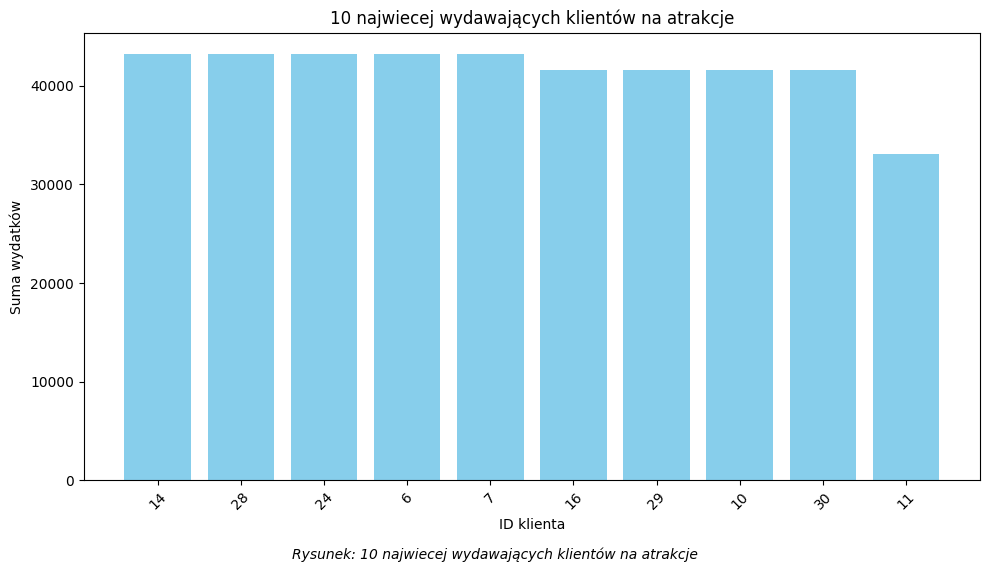

In [34]:
query = """
SELECT 
    k.klient_id,
    k.plec,
    k.data_urodzenia,
    SUM(t.kwota_atrakcji) AS suma_wydatkow,
    t.metoda_id
FROM klienci k
JOIN transakcje t ON k.klient_id = t.klient_id
GROUP BY k.klient_id, k.plec, k.data_urodzenia
ORDER BY suma_wydatkow DESC;
"""

df = pd.read_sql(query, conn)

df = df.sort_values(by="suma_wydatkow", ascending=False)

top_klienci = df.head(10).copy()

today = pd.to_datetime("today")
top_klienci["wiek"] = pd.to_datetime(top_klienci["data_urodzenia"]).apply(
    lambda x: (today - x).days // 365
)
# Tabela top 10 klientów z kolumnami
tabela = "10 najwięcej wydających klientów wg sumy wydatków na atrakcje:"
md_table = tabulate(
    top_klienci[["klient_id", "suma_wydatkow", "plec", "wiek", "metoda_id"]],
    headers='keys',
    tablefmt='github',
    showindex=False
)
display(Markdown(f"**{tabela}**\n\n{md_table}"))

# Statystyki płci i metod płatności jako tabele markdown
plec_stat = top_klienci["plec"].value_counts()
plec_df = plec_stat.reset_index()
plec_df.columns = ['Płeć', 'Liczba']

md_table_plec = tabulate(plec_df, headers='keys', tablefmt='github', showindex=False)
display(Markdown("**Płeć wśród 10 najwięcej wydających klientów:**\n\n" + md_table_plec))

metoda_stat = top_klienci["metoda_id"].value_counts()
metoda_df = metoda_stat.reset_index()
metoda_df.columns = ['Metoda płatności', 'Liczba']

md_table_metoda = tabulate(metoda_df, headers='keys', tablefmt='github', showindex=False)
display(Markdown("**Najczęstsze metody płatności:**\n\n" + md_table_metoda))

# Średni wiek
sredni_wiek = top_klienci["wiek"].mean()
display(Markdown(f"**Średni wiek:** {sredni_wiek:.1f} lat"))

plt.figure(figsize=(10, 6))
plt.bar(top_klienci["klient_id"].astype(str), top_klienci["suma_wydatkow"], color="skyblue")
plt.title("10 najwiecej wydawających klientów na atrakcje")
plt.xlabel("ID klienta")
plt.ylabel("Suma wydatków")
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.figtext(0.5, 0.01, "Rysunek: 10 najwiecej wydawających klientów na atrakcje", ha='center', fontsize=10, style='italic')
plt.show()


In [35]:
def generuj_wnioski_top_klienci(df_top):
    wnioski = []

    # 1. Płeć
    plec_counts = df_top['plec'].value_counts()
    if len(plec_counts) == 2:
        wnioski.append("Wśród top 10 klientów znajduje się po równo kobiet i mężczyzn – po 5 osób.")
    else:
        dominujaca_plec = plec_counts.idxmax()
        wnioski.append(f"Wśród top 10 klientów przeważają osoby płci {dominujaca_plec} – {plec_counts.max()} osób.")

    # 2. Metody płatności
    najczestsza_metoda = df_top['metoda_id'].mode()[0]
    liczba_najczestsza = (df_top['metoda_id'] == najczestsza_metoda).sum()
    wnioski.append(f"Najczęściej stosowana metoda płatności to metoda {najczestsza_metoda} – użyta przez {liczba_najczestsza} klientów.")

    # 3. Średni wiek
    sredni_wiek = df_top['wiek'].mean()
    wnioski.append(f"Średni wiek top 10 klientów wynosi {sredni_wiek:.1f} lat.")

    # 4. Zakres wiekowy
    wiek_min, wiek_max = df_top['wiek'].min(), df_top['wiek'].max()
    wnioski.append(f"Zakres wiekowy tej grupy to od {wiek_min} do {wiek_max} lat.")

    # 5. Top wydatki
    max_kwota = df_top['suma_wydatkow'].max()
    liczba_max = (df_top['suma_wydatkow'] == max_kwota).sum()
    if liczba_max > 1:
        wnioski.append(f"{liczba_max} klientów osiągnęło najwyższy poziom wydatków – po {max_kwota:.2f} zł każdy.")
    else:
        wnioski.append(f"Najwięcej wydał klient z sumą {max_kwota:.2f} zł.")

    # 6. Minimalny wydatek w top 10
    min_kwota = df_top['suma_wydatkow'].min()
    wnioski.append(f"Nawet klient z najmniejszym wydatkiem w top 10 wydał {min_kwota:.2f} zł.")

    return wnioski
wnioski = generuj_wnioski_top_klienci(top_klienci)  # df_top10 to DataFrame jak na Twoim zrzucie

markdown_text = "\n".join(f"* {line.strip()}" for line in wnioski if line.strip())

display(Markdown(markdown_text))

* Wśród top 10 klientów znajduje się po równo kobiet i mężczyzn – po 5 osób.
* Najczęściej stosowana metoda płatności to metoda 1 – użyta przez 9 klientów.
* Średni wiek top 10 klientów wynosi 39.6 lat.
* Zakres wiekowy tej grupy to od 19 do 66 lat.
* 5 klientów osiągnęło najwyższy poziom wydatków – po 43210.00 zł każdy.
* Nawet klient z najmniejszym wydatkiem w top 10 wydał 33110.00 zł.

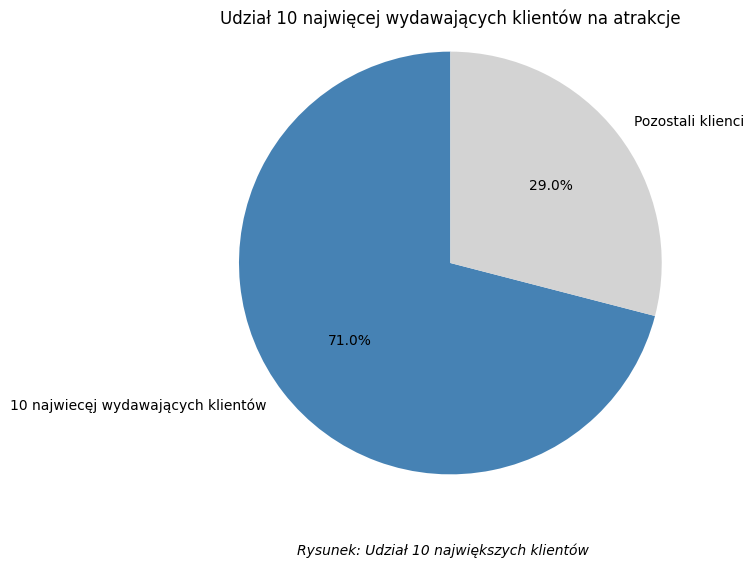

In [36]:
suma_top10 = top_klienci["suma_wydatkow"].sum()
suma_reszta = df["suma_wydatkow"].sum() - suma_top10

dane_pie = [suma_top10, suma_reszta]
etykiety = ["10 najwiecęj wydawających klientów", "Pozostali klienci"]
kolory = ["steelblue", "lightgray"]

plt.figure(figsize=(6, 6))
plt.pie(dane_pie, labels=etykiety, autopct="%1.1f%%", colors=kolory, startangle=90)
plt.title("Udział 10 najwięcej wydawających klientów na atrakcje")
plt.axis("equal")  
plt.figtext(0.5, 0.01, "Rysunek: Udział 10 największych klientów", ha='center', fontsize=10, style='italic')
plt.show()


In [37]:
def generuj_wnioski_wydatki_top10(top_klienci, df):
    suma_top10 = top_klienci["suma_wydatkow"].sum()
    suma_reszta = df["suma_wydatkow"].sum() - suma_top10
    procent_top10 = (suma_top10 / (suma_top10 + suma_reszta)) * 100
    
    wnioski = []
    wnioski.append(f"10 najwięcej wydających klientów odpowiada za około {procent_top10:.1f}% wszystkich wydatków na dodatkowe atrakcje.")
    wnioski.append(f"Pozostali klienci generują łącznie około {100 - procent_top10:.1f}% wydatków, co wskazuje na dużą koncentrację wydatków w wąskiej grupie klientów.")
    wnioski.append("Taki rozkład sugeruje, że programy lojalnościowe lub oferty specjalne skierowane do tych kluczowych klientów mogą znacząco zwiększyć przychody z atrakcji.")
    
    return wnioski


wnioski = generuj_wnioski_wydatki_top10(top_klienci, df)
markdown_text = "\n".join(f"* {line.strip()}" for line in wnioski if line.strip())

display(Markdown(markdown_text))


* 10 najwięcej wydających klientów odpowiada za około 71.0% wszystkich wydatków na dodatkowe atrakcje.
* Pozostali klienci generują łącznie około 29.0% wydatków, co wskazuje na dużą koncentrację wydatków w wąskiej grupie klientów.
* Taki rozkład sugeruje, że programy lojalnościowe lub oferty specjalne skierowane do tych kluczowych klientów mogą znacząco zwiększyć przychody z atrakcji.

## Ilu klientow jest uczulonych na gluten i ktore dania sa dla nich bezpieczne do spozywania na statku

In [ ]:


try:

    cursor = conn.cursor(dictionary=True)

    cursor.execute("""
        SELECT COUNT(DISTINCT klient_id) AS liczba_uczulonych
        FROM klient_alergen
        WHERE alergen_id = (
            SELECT alergen_id FROM alergeny WHERE nazwa = 'gluten'
        )
    """)
    wynik1 = cursor.fetchone()
    liczba_uczulonych = wynik1['liczba_uczulonych']
    print(f"Liczba klientów uczulonych na gluten: {liczba_uczulonych}")

    cursor.execute("""
        SELECT j.jedzenie_id, j.danie
        FROM jedzenie j
        WHERE j.jedzenie_id NOT IN (
            SELECT ja.jedzenie_id
            FROM jedzenie_alergen ja
            JOIN alergeny a ON ja.alergen_id = a.alergen_id
            WHERE a.nazwa = 'gluten'
        )
        ORDER BY j.danie
    """)
    wszystkie_posilki = cursor.fetchall()

    unikalne_posilki = {}
    for posilek in wszystkie_posilki:
        nazwa = posilek['danie']
        if nazwa not in unikalne_posilki:
            unikalne_posilki[nazwa] = posilek

    print("\nPosiłki bez glutenu (unikalne nazwy):")
    for posilek in unikalne_posilki.values():
        print(f"- {posilek['jedzenie_id']} | {posilek['danie']}")


    if liczba_uczulonych == 0:
        print("Brak klientów uczulonych na gluten, co może wskazywać na niską zachorowalność lub niedostateczną rejestrację uczuleń.")
    elif liczba_uczulonych < 5:
        print("Niewielka liczba klientów uczulonych na gluten, prawdopodobnie problem nie jest bardzo powszechny.")
    else:
        print(f"Liczba klientów uczulonych na gluten ({liczba_uczulonych}) wskazuje na konieczność uwzględnienia posiłków bezglutenowych w ofercie.")

    liczba_posilkow = len(unikalne_posilki)
    print(f"Dostępnych jest {liczba_posilkow} unikalnych dań bezglutenowych.")

    if liczba_posilkow == 0:
        print("Brak dostępnych posiłków bezglutenowych, co może stanowić problem dla osób uczulonych.")
    elif liczba_posilkow < 10:
        print("Oferta posiłków bezglutenowych jest ograniczona, warto rozważyć jej rozszerzenie.")
    else:
        print("Oferta posiłków bezglutenowych jest stosunkowo bogata, co dobrze wspiera potrzeby klientów uczulonych.")

except mysql.connector.Error as err:
    print(f"Błąd: {err}")

finally:
    if conn.is_connected():
        cursor.close()
        conn.close()

Liczba klientów uczulonych na gluten: 7

Posiłki bez glutenu (unikalne nazwy):
- J06 | batonik proteinowy
- J64 | chia pudding z mlekiem roślinnym i owocami
- J05 | czekolada
- J53 | jajecznica z boczkiem
- J52 | jajecznica ze szczypiorkiem
- J16 | omlet z warzywami i serem
- J09 | orzeszki
- J46 | pad thai z kurczakiem
- J47 | pad thai z warzywami
- J43 | pieczona ciecierzyca z batatami i sosem tahini
- J11 | popcorn
- J24 | serek wiejski z pomidorami i pieczywem
- J13 | skyr pitny
- J28 | smoothie bowl
- J42 | tofu curry z mlekiem kokosowym i warzywami
- J04 | żelki
Liczba klientów uczulonych na gluten (7) wskazuje na konieczność uwzględnienia posiłków bezglutenowych w ofercie.
Dostępnych jest 16 unikalnych dań bezglutenowych.
Oferta posiłków bezglutenowych jest stosunkowo bogata, co dobrze wspiera potrzeby klientów uczulonych.
